In [434]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

In [4]:
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=300000_S=200_M=20_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [5]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [6]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.70441 -- accuracy=94.54%  
  valid loss:		0.37986
  valid accuracy:	0.95859+/-0.01617
  valid auc-roc:	0.93374+/-0.06799
  valid auc-pr:		0.58690+/-0.28604
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.26412 -- accuracy=96.51%  
  valid loss:		0.15603
  valid accuracy:	0.97733+/-0.01242
  valid auc-roc:	0.97587+/-0.04146
  valid auc-pr:		0.81150+/-0.26622
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.13805 -- accuracy=98.04%  
  valid loss:		0.10444
  valid accuracy:	0.98774+/-0.00852
  valid auc-roc:	0.99064+/-0.02245
  valid auc-pr:		0.90533+/-0.20202
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000

In [7]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 20, 200, 1)
parameters: W
layer3: 
shape:(None, 20, 200, 1)
parameters: b
layer4: 
shape:(None, 20, 200, 1)
parameters: beta, gamma, mean, inv_std
layer5: 
shape:(None, 20, 200, 1)
layer6: 
shape:(None, 20, 50, 1)
layer7: 
shape:(None, 40, 50, 1)
parameters: W
layer8: 
shape:(None, 40, 50, 1)
parameters: b
layer9: 
shape:(None, 40, 50, 1)
parameters: beta, gamma, mean, inv_std
layer10: 
shape:(None, 40, 50, 1)
layer11: 
shape:(None, 40, 25, 1)
layer12: 
shape:(None, 200)
parameters: W
layer13: 
shape:(None, 200)
parameters: b
layer14: 
shape:(None, 200)
layer15: 
shape:(None, 200)
layer16: 
shape:(None, 20)
parameters: W
layer17: 
shape:(None, 20)
parameters: b
layer18: 
shape:(None, 20)
------------------------------------------------------------------------

In [8]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f2f7efbb710>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f2f7f013850>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f2f7ef66d90>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f2fe11fd090>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f2f7ef83e50>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f2f7ef83e90>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f2f7ef931d0>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f2f7ef93050>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f2f7ef83ed0>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f2f7ef93710>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7f2f7ef93750>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f2f7ef93c50>,
 'dense1_bias': <lasagne.layers.special.BiasLayer at 0x7f2f7ef93790>,
 'dense1_dropout': <lasagne.layers.noise.DropoutLayer at

In [1055]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)



def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt

def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype('float32'), y[excerpt].astype('int32')


def get_feature_map_all(layer, input_var, X, batch_size=500):
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        fmaps[index] = feature_maps(X[index])
    return fmaps

def get_feature_map(layer, input_var, X, index):
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    
    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    return feature_maps(X[index])

def pseudoinverse_filter2(W1):
    #W1 = W1.transpose([2,0,1,3])
    weight = np.squeeze(W1)    
    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

In [1031]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(10000)
X = train[0][map_index]
X = np.expand_dims(X,0)
y = np.argmax(train[1][map_index])

def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = np.squeeze(X[i])
        if norm == 1:
            for i in range(5):
                x[:,:10]=0
                x[:,-10:]=0
                MEAN = np.nanmean(x,axis=1)
                x -= np.outer(MEAN, np.ones(x.shape[1]))
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm

model = []
for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    model.append(get_class_pwm(np.squeeze(X), class_index))


# Sensitivity analysis (single sequence)

In [3975]:
#X2, labels = reconstruct_layer2(network, train)
map_index = 271  #37 is hard
X = train[0][map_index]
X = np.expand_dims(X,0)
y = np.argmax(train[1][map_index])
print X.shape

(1, 4, 200, 1)


In [3976]:
# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
prediction = np.argmax(prediction)
print 'ground truth = ' + str(y)
print 'prediction = ' + str(prediction)

ground truth = 5
prediction = 5


In [3977]:
# get dense layer
get_dense1 = theano.function([nnmodel.input_var], layers.get_output(network['dense1_active'], deterministic=True), allow_input_downcast=True)
dense1 = get_dense1(X)
num_units = len(dense1)

W = network['dense2'].W.get_value()
b = network['dense2_bias'].b.get_value()

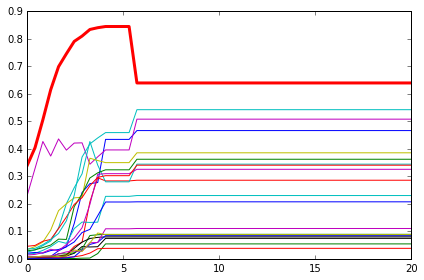

In [3978]:
# monitor prediciton effect for various filter thresholds 
Z = T.dmatrix()
get_prediction2 = theano.function([Z], get_output(network['output'], {network['dense1_active']:Z}, deterministic=True), allow_input_downcast=True)

vals = np.linspace(0,20,50)
z = []
for thresh in vals:
    test = np.copy(dense1)
    test[test < thresh] = 0
    prediction2 = get_prediction2(test)
    z.append(prediction2[0])
z = np.array(z)

# plot the predictions
plt.figure()
plt.plot(vals,z);
plt.plot(vals,z[:,prediction],linewidth=3,color='r')

z = z[:,prediction]

In [3979]:
percent = .1
num_units = len(dense1[0])
index = int(num_units*percent)
threshold = np.sort(dense1[0])[-index]
print threshold
#threshold = np.outer(threshold, np.ones(num_units))

2.25864


[ 0.06970277  0.00093395  0.04466994  0.09600651  0.39829219  0.7792546
  0.01879721  0.06173049  0.02115931  0.00688604  0.27456888  0.07457333
  0.20773237  0.03563754  0.00569813  0.12571814  0.20886156  0.2334683
  0.02779887  0.02977971]


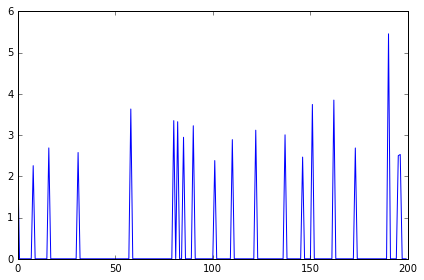

In [3980]:
# filter dense layer and plot activations
dense1[dense1 < threshold] = 0
prediction2 = get_prediction2(dense1)
print prediction2[0]

plt.figure()
plt.plot(dense1[0])

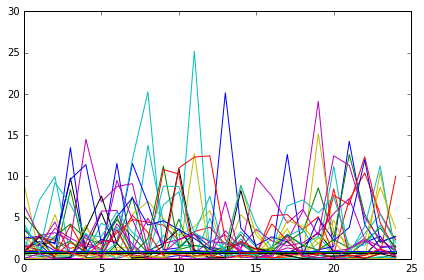

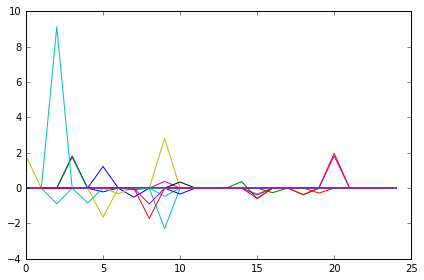

In [3981]:
W = network['dense1'].W.get_value()
b = network['dense1_bias'].b.get_value()

# psuedo-inverse filters
U, s, V = np.linalg.svd(W, full_matrices=True)
S = np.zeros(W.T.shape)
S[:W.shape[1],:W.shape[1]] = np.diag(1/s)
Winv = np.dot(V.T,np.dot(S, U.T))

# inverse the activation
num_units = dense1.shape[0]
inverse =  dense1 #np.log(np.exp(dense1) - 1 + 1e-7) #dense1 #
#inverse -= np.outer(np.ones(num_units),b)
inverse = np.dot(inverse, W.T)

shape = get_output_shape(network['conv2_pool'])
shape = (-1, shape[1], shape[2], shape[3])
pool = inverse.reshape(shape)

# original pool
get_pool = theano.function([nnmodel.input_var], layers.get_output(network['conv2_pool'], deterministic=True), allow_input_downcast=True)
pool2 = get_pool(X)
plt.figure()
plt.plot(np.squeeze(pool2[0].T));

# reconstructed pool
plt.figure()
plt.plot(np.squeeze(pool[0].T));

In [3982]:
#pool = get_pool(X)
Z = T.dmatrix()
get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

test = np.reshape(pool,[1,-1])
prediction2 = get_prediction2(test)

print np.argmax(prediction2)
print prediction2

4
[[ 0.01157482  0.00096293  0.0198609   0.01309757  0.30024524  0.22575303
   0.01031472  0.03235125  0.00780346  0.00542369  0.1329021   0.02921002
   0.15845824  0.01321447  0.0018207   0.07776853  0.11419392  0.11468812
   0.0179253   0.00458422]]


array([2])

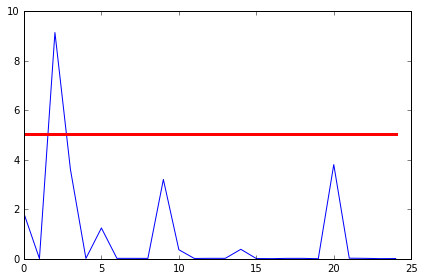

In [3985]:
val = np.squeeze(pool[0])
val[val < 0] = 0

spikes = np.sum(val,axis=0)
num_units = len(spikes)
plt.plot(spikes.T)
threshold = np.mean(spikes) +  np.std(spikes)*2
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)
index = np.where(spikes > threshold)[0]
index

val = np.squeeze(pool[0])
val[val < 0] = 0

# variance filter
var = np.var(val,axis=0)
num_units = len(var)
plt.figure()
plt.plot(var)
threshold = np.mean(var) + np.std(var)/10
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)
index = np.where(var > threshold)[0]
index

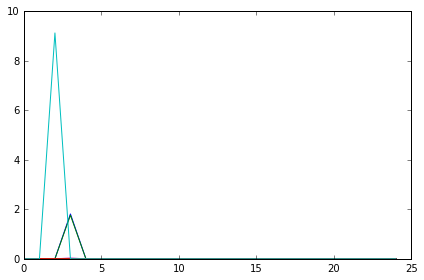

In [3986]:

window = 1
filter_map = np.zeros(val.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(val.shape[1],i+window)
    filter_map[:,MIN:MAX+1] = val[:,MIN:MAX+1]
    
filter_map[filter_map < 0] = 0
plt.figure()
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


pool = filter_map

#prediction2 = get_prediction2(pool)
#print np.argmax(prediction2[0])
#print prediction2[0]


In [3987]:

# max-unpool layer 2
active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
pool_size = active.shape[2]/pool.shape[2]
fmap2 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index= []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)


In [3988]:
# psuedo-inverse filters
W2 = network['conv2'].W.get_value()
W2_inv = pseudoinverse_filter2(W2)

# deconvolution layer 2
input_var2 = T.tensor4('fmap')
shape2 = list(fmap2.shape)
shape2[0] = None
input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
#unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
#unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(input2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
predict = theano.function([input_var2], get_output(deconv2, deterministic=True), allow_input_downcast=True)

intermediate = predict(fmap2.astype(np.float32))
intermediate = np.array(intermediate)

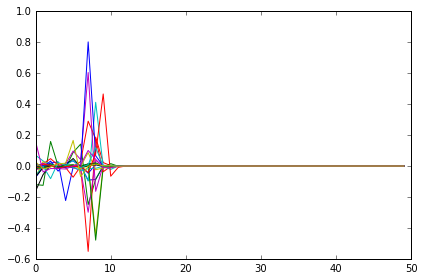

In [3989]:
x =  np.squeeze(intermediate[0])
#x[x<0] = 0
plt.plot(x.T);

vals = intermediate
vals[vals < 0] = 0
spikes = np.sum(vals,axis=0)
plt.plot(spikes)

threshold = np.mean(spikes) +  np.std(spikes)
print threshold

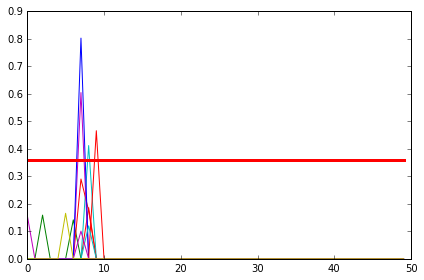

In [3991]:
x[x < 0.1] = 0
spikes = np.sum(x,axis=0)
num_units = len(spikes)
plt.plot(x.T)
threshold = np.mean(spikes) +  np.std(spikes)
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)


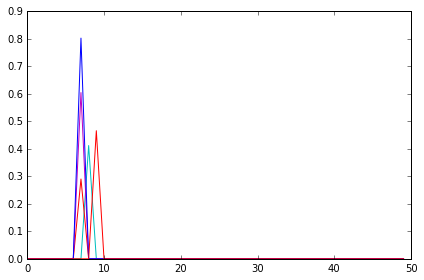

In [3992]:
# filter intermediate layer
window = 1
val = np.max(x,axis=0)
index = np.where(val > threshold)[0]
filter_map = np.zeros(x.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(x.shape[1],i+window)
    if MAX+1 > MIN:
        filter_map[:,MIN:MAX+1] = x[:,MIN:MAX+1]

filter_map[filter_map < 0.2] = 0
plt.plot(filter_map.T)
filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


In [3993]:
pool = filter_map

# max-unpool layer 1
active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

pool_size = active.shape[2]/pool.shape[2]
fmap1 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap1.append(fmap_unpool)

fmap1 = np.array(fmap1)
fmap1 = np.expand_dims(fmap1, 3)


W1 = network['conv1'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)


# deconvolution layer 1
input_var1 = T.tensor4('fmap')
shape1 = list(fmap1.shape)
shape1[0] = None
input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)


reconstruction = theano.function([input_var1], get_output(deconv1, deterministic=True), allow_input_downcast=True)

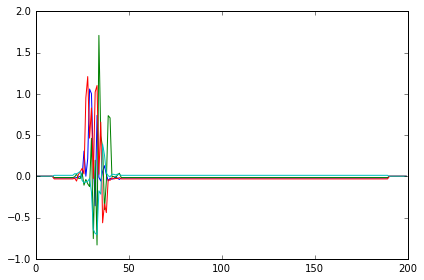

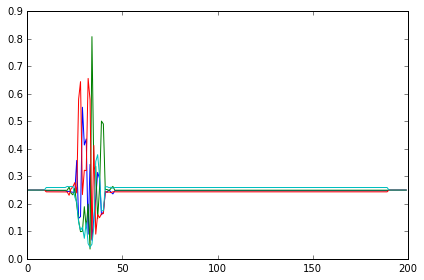

In [3994]:
X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

x = X2
for i in range(5):
    x[:,:10]=0
    x[:,-10:]=0
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
    
plt.figure()
plt.plot(x.T)

x /= np.log(2)
x = np.exp(x)
sumX = np.sum(x,axis=0) 
x /= np.outer(np.ones(4),sumX)

plt.figure()
plt.plot(x.T)

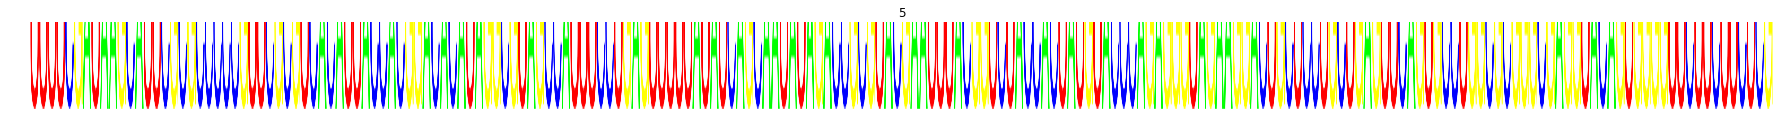

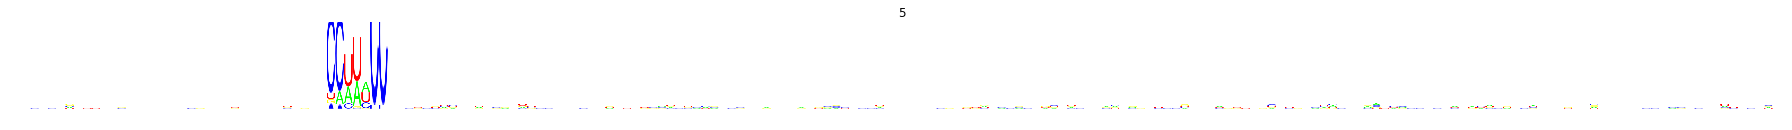

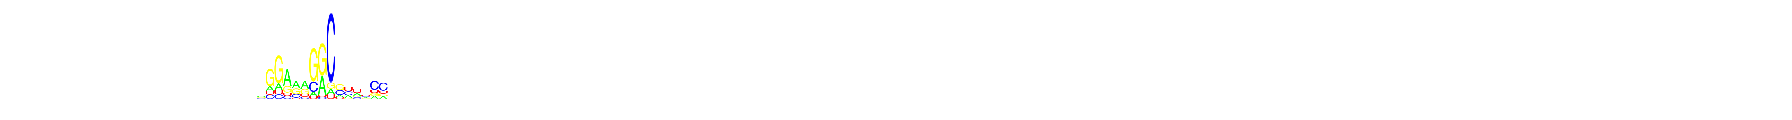

In [3995]:

height=300
bp_width=30
num_seq = X2.shape[1]
width = bp_width*num_seq
size = (25.,25.0)


logo = seq_logo(np.squeeze(X[0]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));


logo = seq_logo(np.squeeze(model[y]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));


logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

# one time go

In [4004]:
def IdentifyMotifs(X, prediction, nnmodel, network):
    
    # get dense layer
    get_dense1 = theano.function([nnmodel.input_var], layers.get_output(network['dense1_active'], deterministic=True), allow_input_downcast=True)
    dense1 = get_dense1(X)
    num_units = len(dense1)
    
    W = network['dense2'].W.get_value()
    b = network['dense2_bias'].b.get_value()
    
    
    # monitor prediciton effect for various filter thresholds 
    Z = T.dmatrix()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['dense1_active']:Z}, deterministic=True), allow_input_downcast=True)

    vals = np.linspace(0,20,50)
    z = []
    for thresh in vals:
        test = np.copy(dense1)
        test[test < thresh] = 0
        prediction2 = get_prediction2(test)
        z.append(prediction2[0])
    z = np.array(z)
    z = z[:,prediction]

    percent = .1
    num_units = len(dense1[0])
    index = int(num_units*percent)
    threshold = np.sort(dense1[0])[-index]
    
    # filter dense layer and plot activations
    dense1[dense1 < threshold] = 0
    prediction2 = get_prediction2(dense1)
    
    
    W = network['dense1'].W.get_value()
    b = network['dense1_bias'].b.get_value()

    # inverse the activation
    num_units = dense1.shape[0]
    inverse =  dense1 #np.log(np.exp(dense1) - 1 + 1e-7) #dense1 #
    inverse = np.dot(inverse, W.T)
    shape = get_output_shape(network['conv2_pool'])
    shape = (-1, shape[1], shape[2], shape[3])
    pool = inverse.reshape(shape)

    
    val = np.squeeze(pool[0])
    val[val < 0] = 0
    spikes = np.sum(val,axis=0)
    num_units = len(spikes)
    threshold = np.mean(spikes) +  np.std(spikes)/4
    index = np.where(spikes > threshold)[0]

    window = 1
    filter_map = np.zeros(val.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(val.shape[1],i+window)
        filter_map[:,MIN:MAX+1] = val[:,MIN:MAX+1]

    filter_map[filter_map < 0] = 0
    filter_map = np.expand_dims(filter_map,0)
    filter_map = np.expand_dims(filter_map,3)
    pool = filter_map

    # max-unpool layer 2
    active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
    pool_size = active.shape[2]/pool.shape[2]
    fmap2 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index= []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):

            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap2.append(fmap_unpool)

    fmap2 = np.array(fmap2)
    fmap2 = np.expand_dims(fmap2, 3)

    # psuedo-inverse filters
    W2 = network['conv2'].W.get_value()
    W2_inv = pseudoinverse_filter2(W2)

    # deconvolution layer 2
    input_var2 = T.tensor4('fmap')
    shape2 = list(fmap2.shape)
    shape2[0] = None
    input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
    deconv2 = Conv2DLayer(input2, num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
    predict = theano.function([input_var2], get_output(deconv2, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap2.astype(np.float32))
    intermediate = np.array(intermediate)

    x =  np.squeeze(intermediate[0])
    x[x < 0] = 0
    spikes = np.sum(x,axis=0)
    num_units = len(spikes)
    threshold = np.mean(spikes) +  np.std(spikes)/4

    # filter intermediate layer
    window = 0
    val = np.max(x,axis=0)
    index = np.where(val > threshold)[0]
    filter_map = np.zeros(x.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(x.shape[1],i+window)
        if MAX+1 > MIN:
            filter_map[:,MIN:MAX+1] = x[:,MIN:MAX+1]

    filter_map[filter_map < .2] = 0
    filter_map = np.expand_dims(filter_map,0)
    filter_map = np.expand_dims(filter_map,3)

    pool = filter_map

    # max-unpool layer 1
    active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)


    W1 = network['conv1'].W.get_value()
    W1_inv = pseudoinverse_filter2(W1)


    # deconvolution layer 1
    input_var1 = T.tensor4('fmap')
    shape1 = list(fmap1.shape)
    shape1[0] = None
    input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
    unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
    deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)

    reconstruction = theano.function([input_var1], get_output(deconv1, deterministic=True), allow_input_downcast=True)

    X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

    x = X2
    for i in range(5):
        x[:,:10]=0
        x[:,-10:]=0
        MEAN = np.nanmean(x,axis=1)
        x -= np.outer(MEAN, np.ones(x.shape[1]))

    x /= np.log(2)
    x = np.exp(x)
    sumX = np.sum(x,axis=0) 
    x /= np.outer(np.ones(4),sumX)
    return x


ground truth = 10


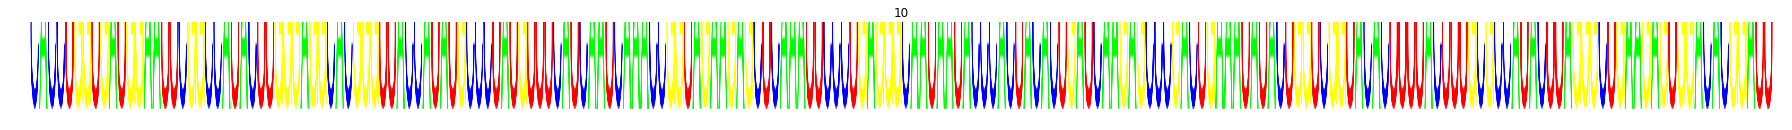

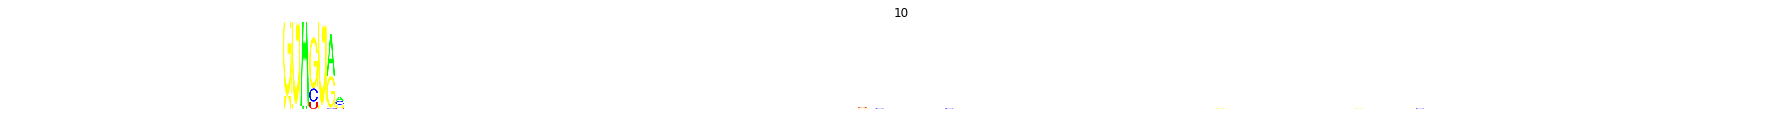

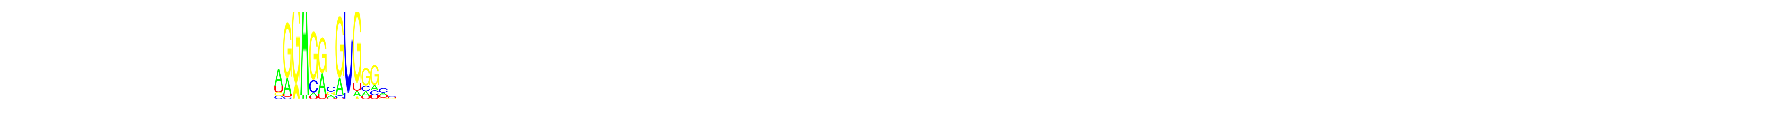

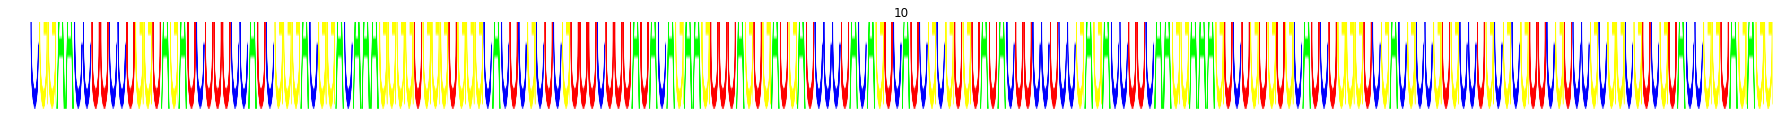

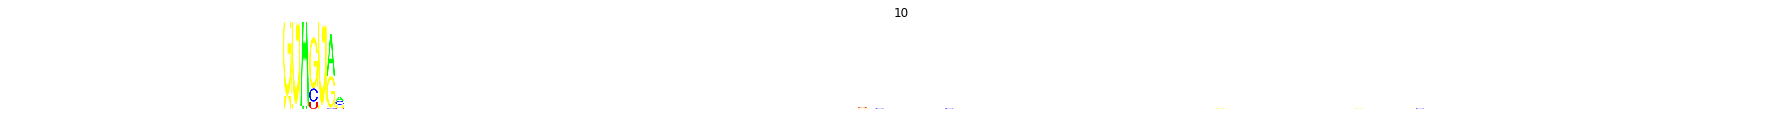

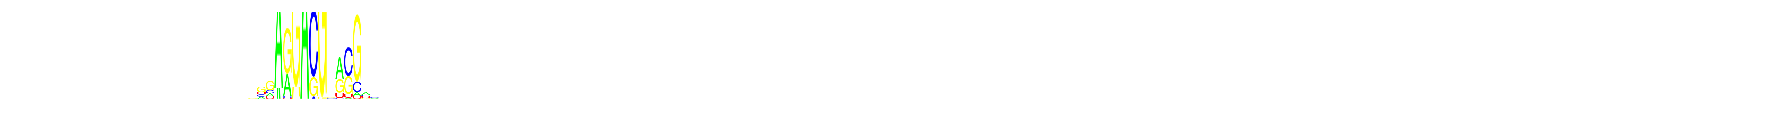

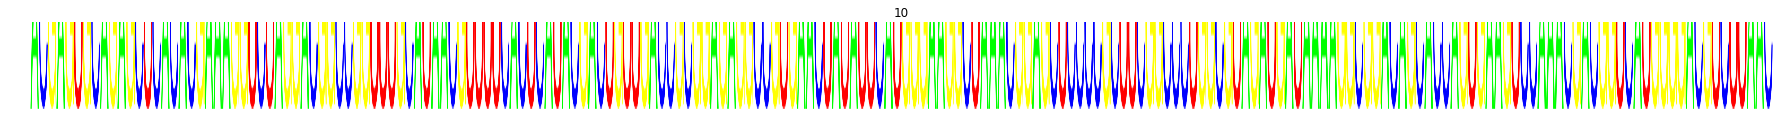

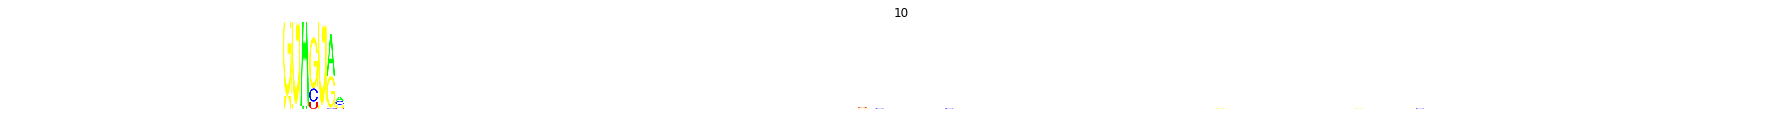

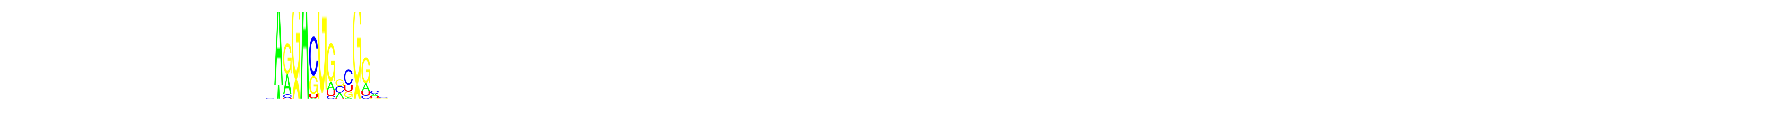

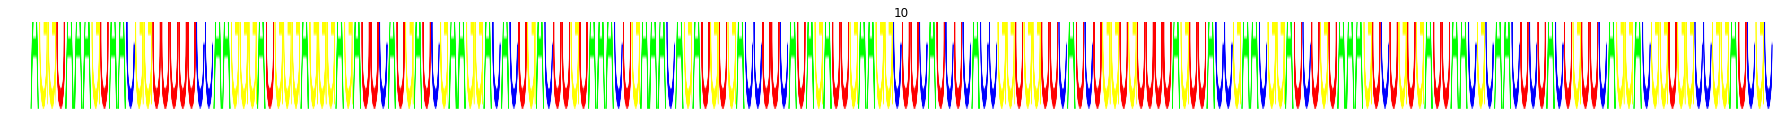

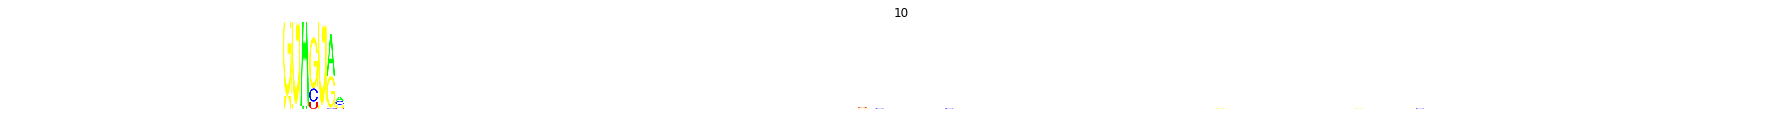

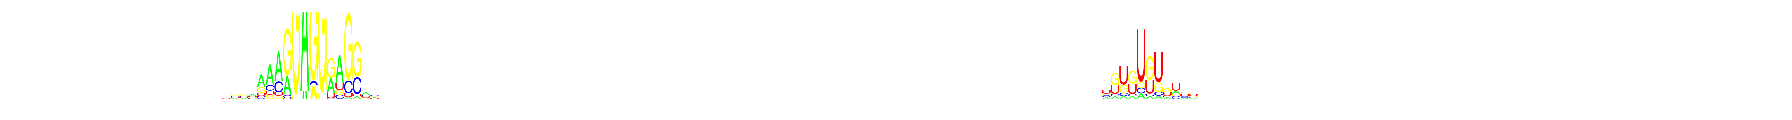

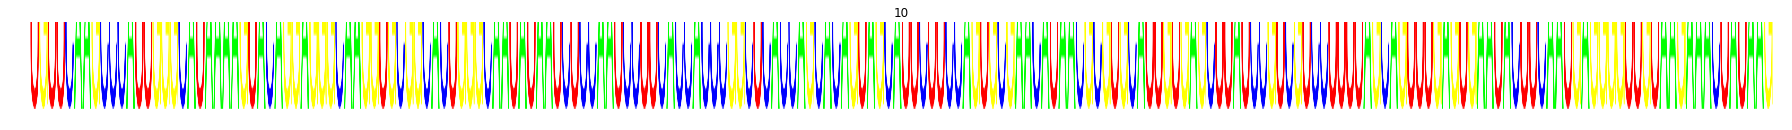

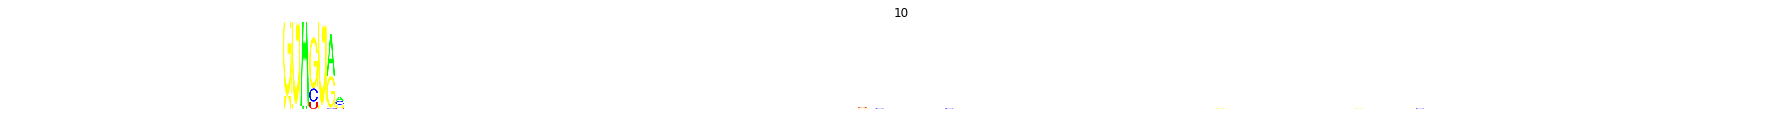

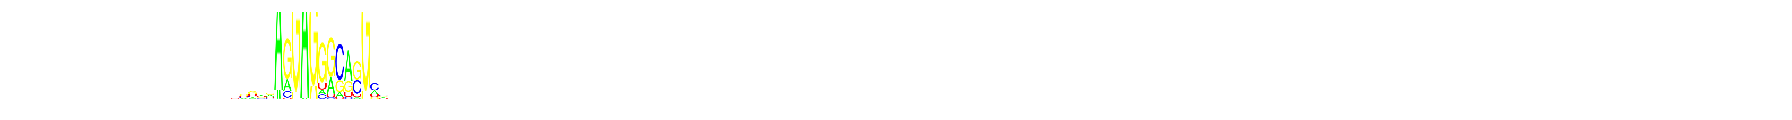

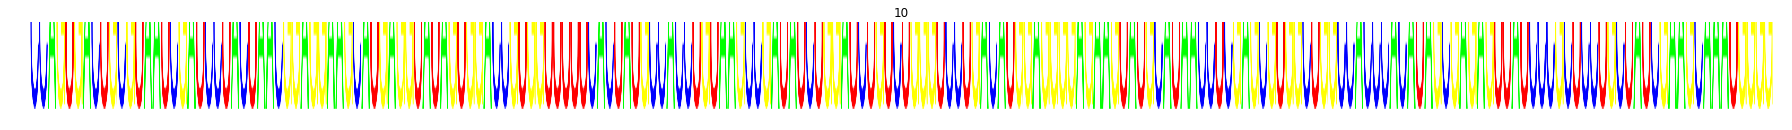

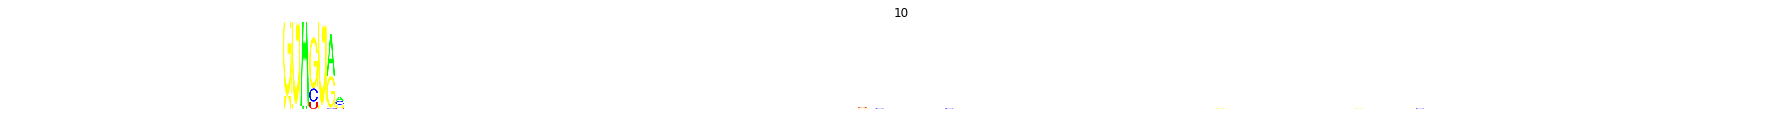

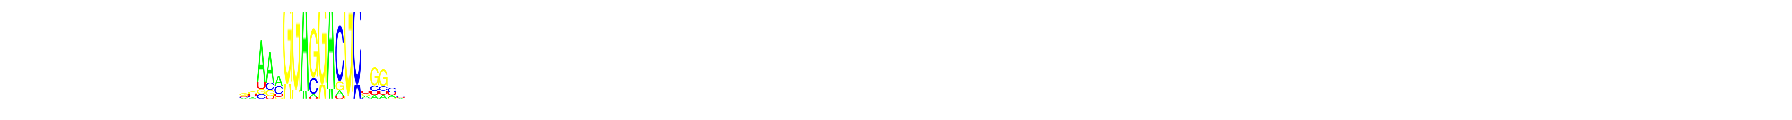

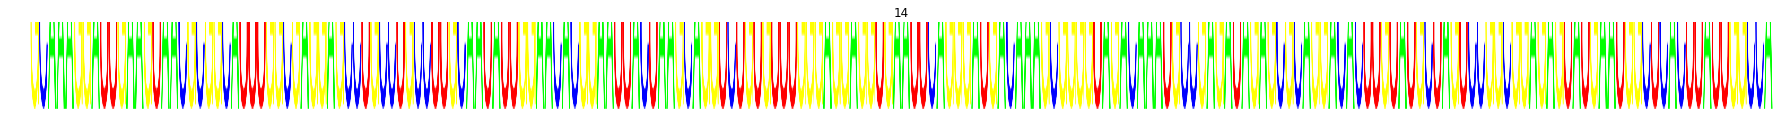

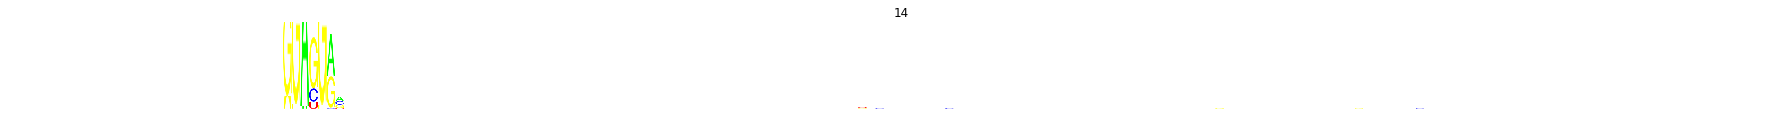

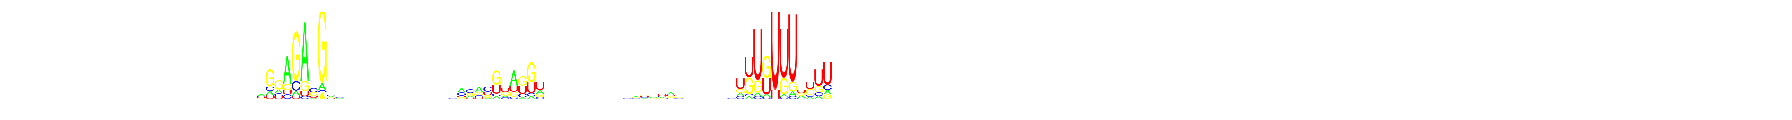

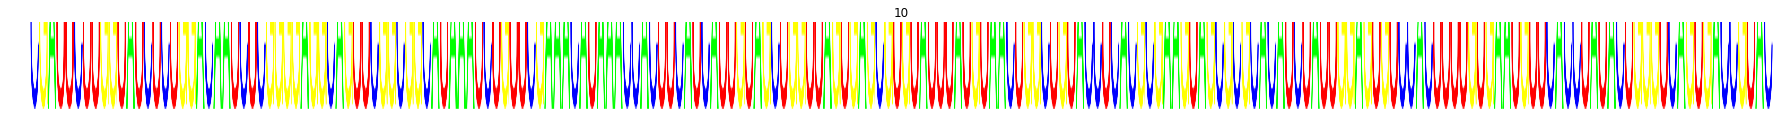

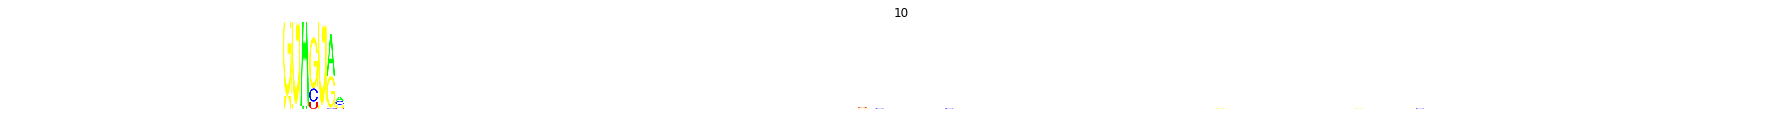

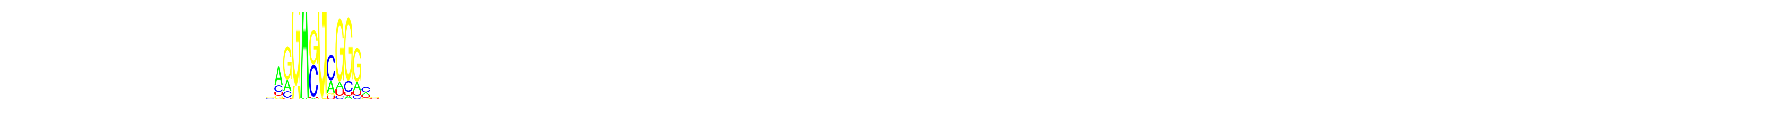

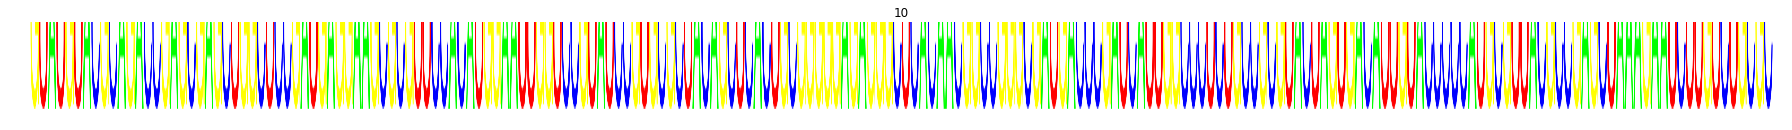

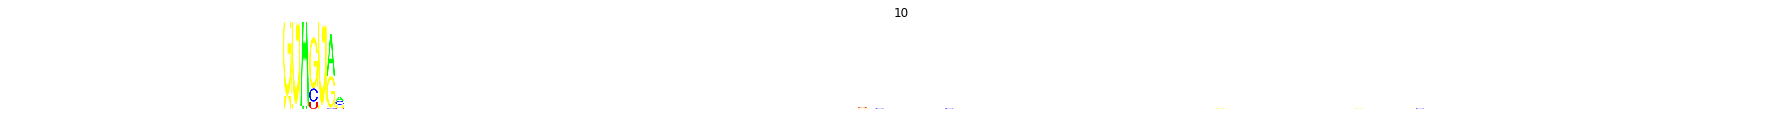

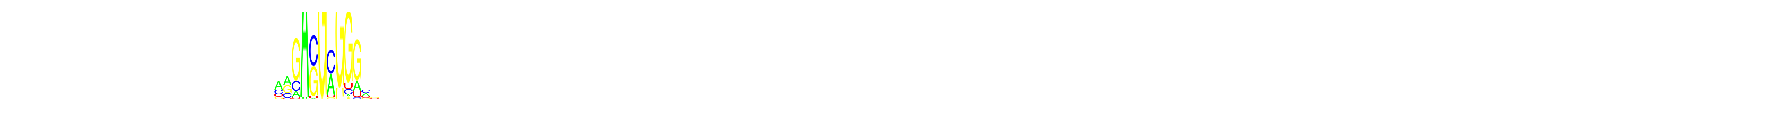

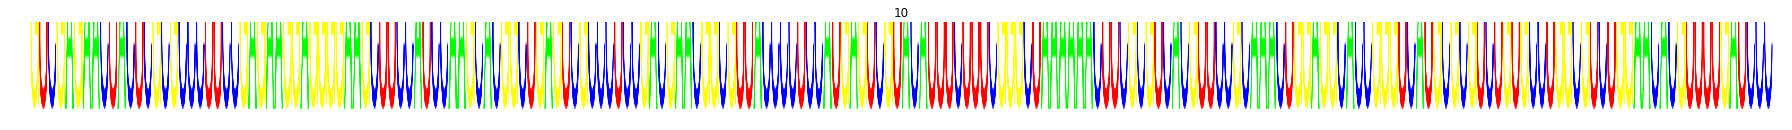

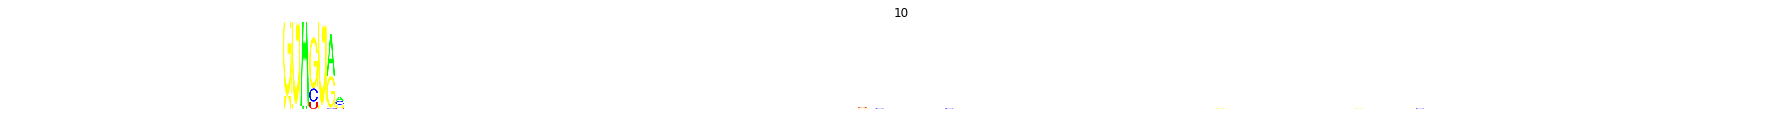

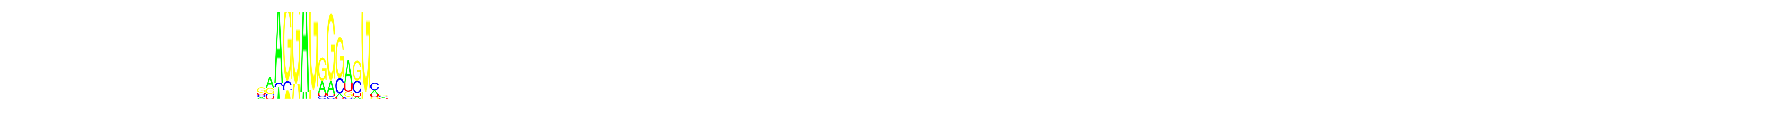

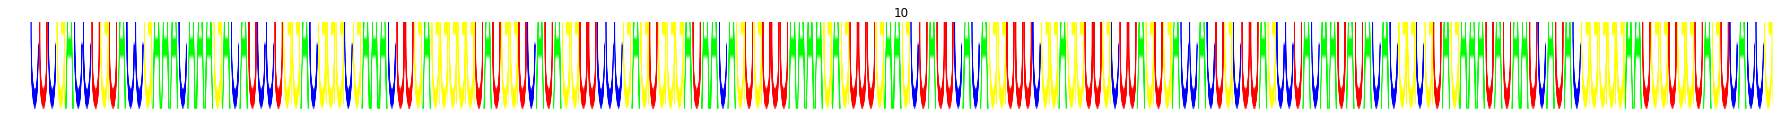

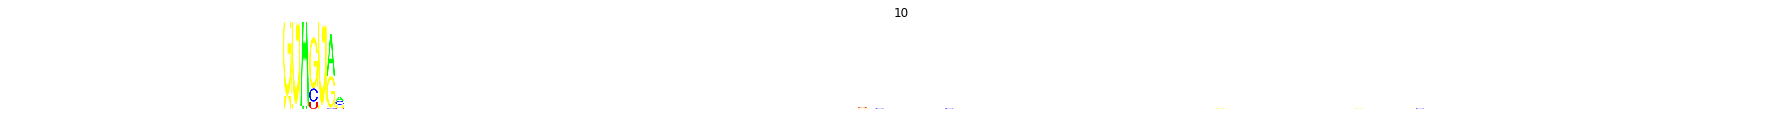

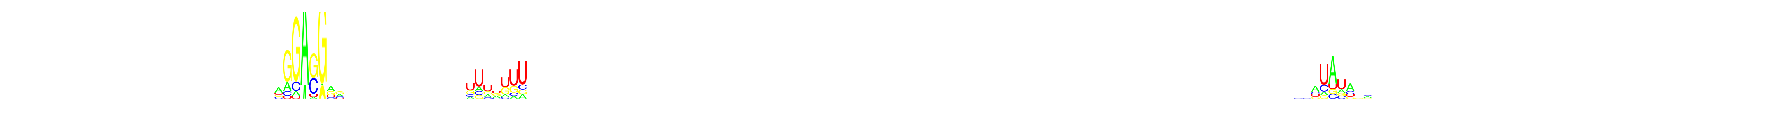

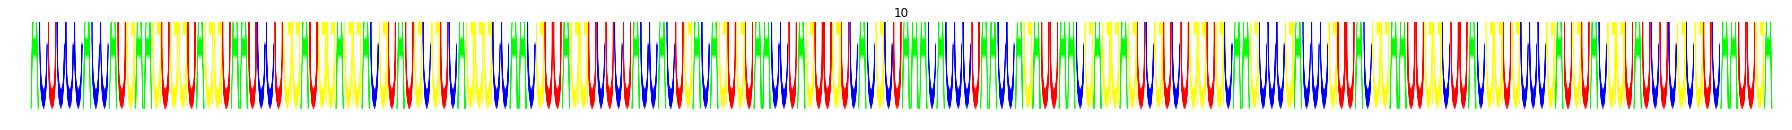

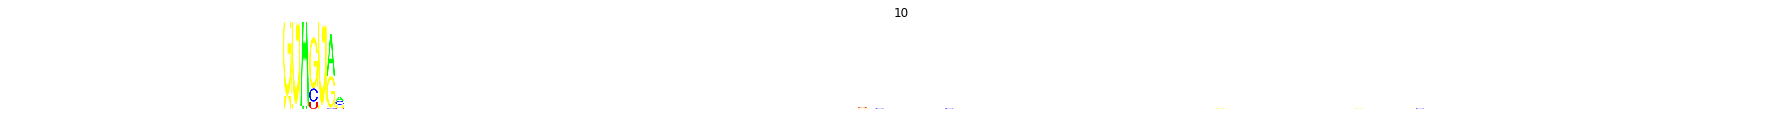

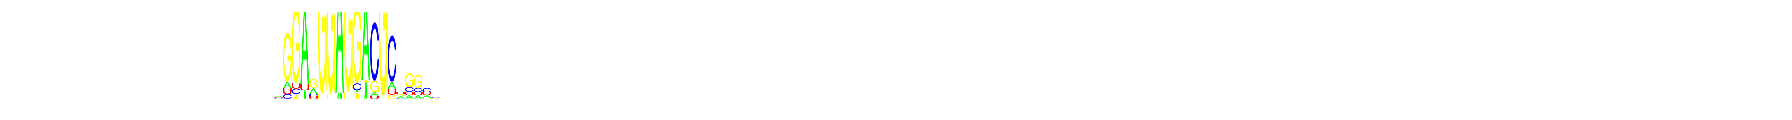

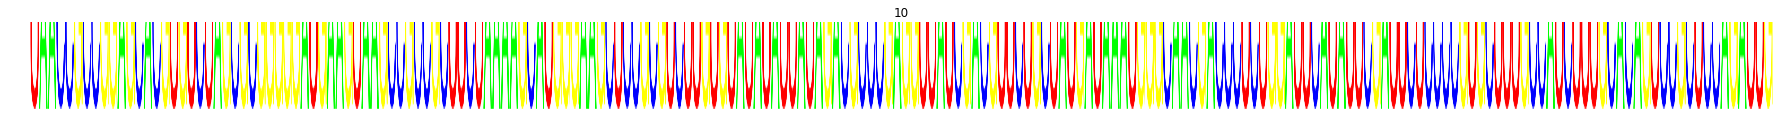

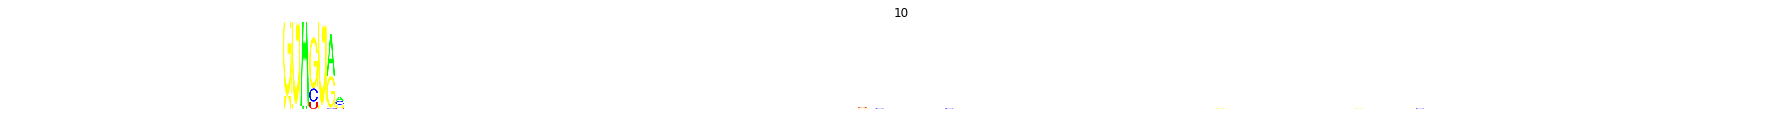

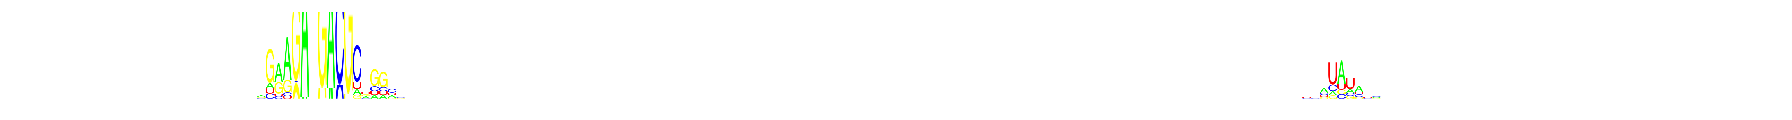

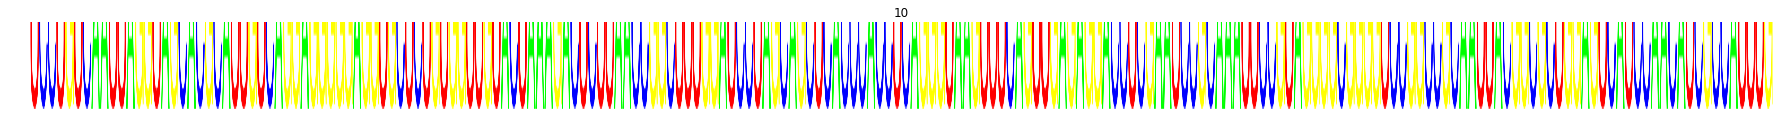

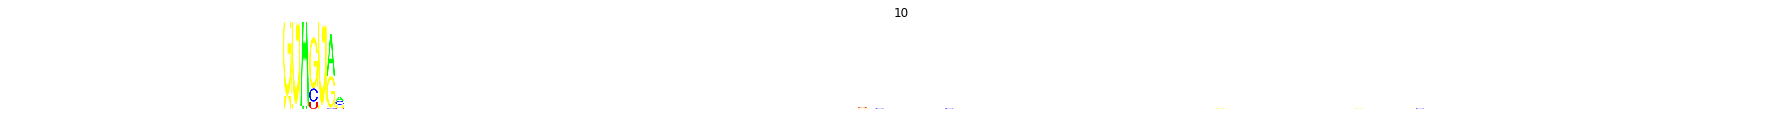

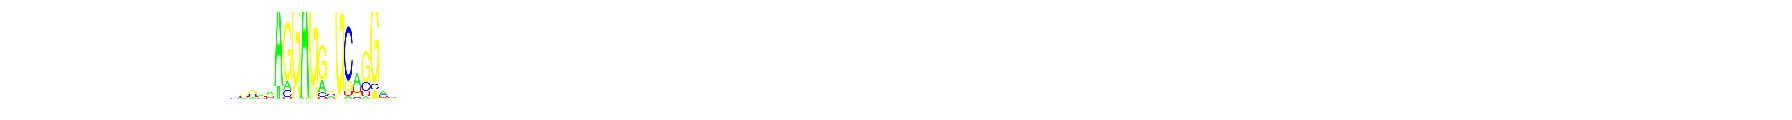

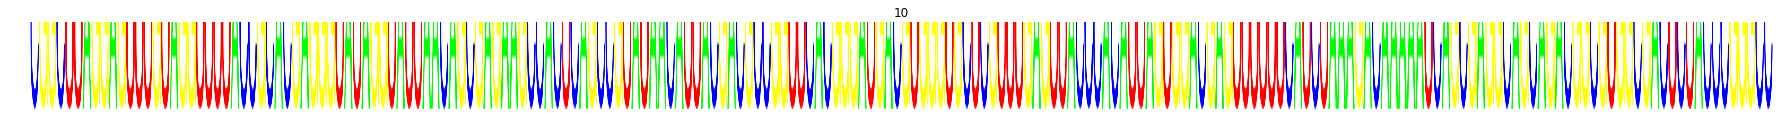

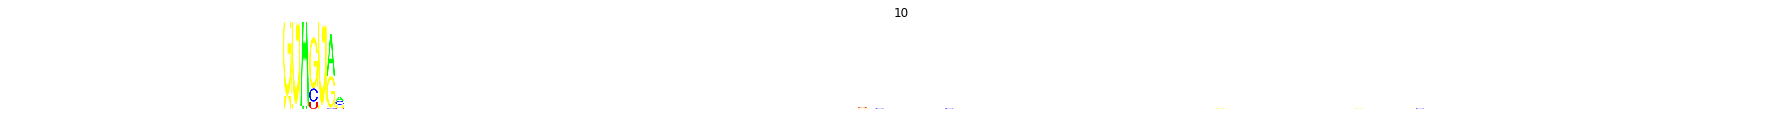

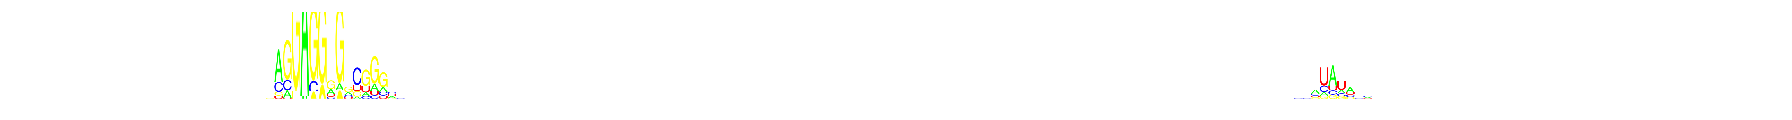

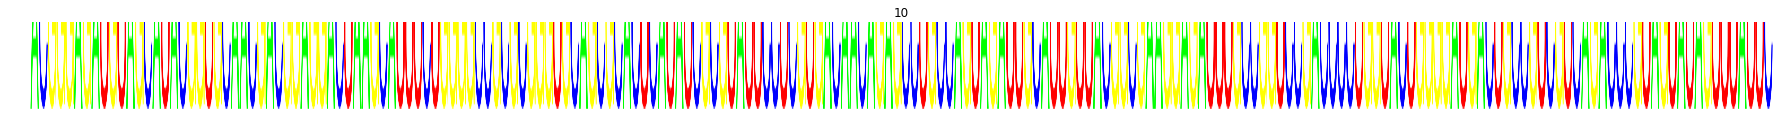

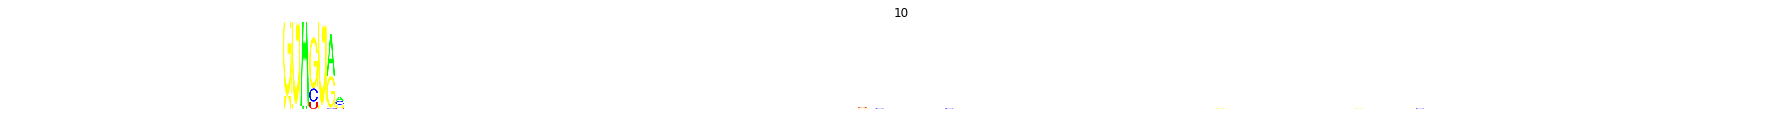

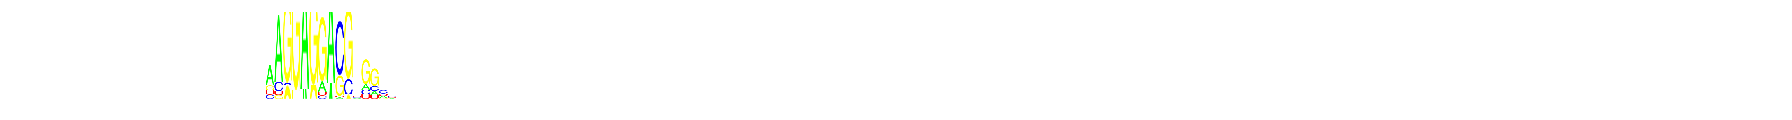

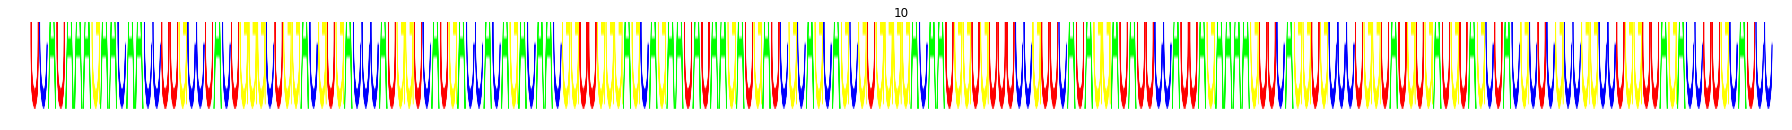

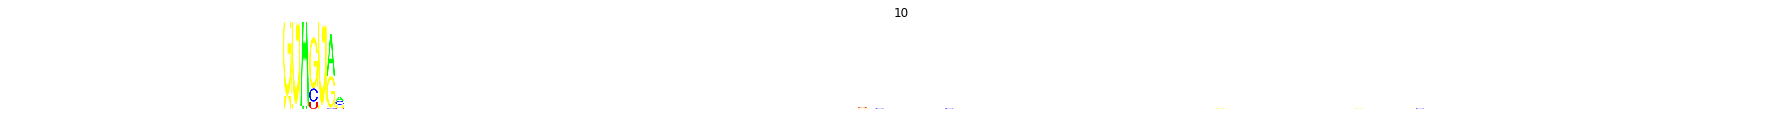

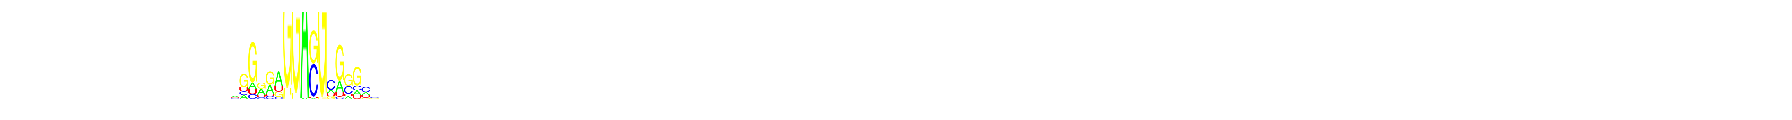

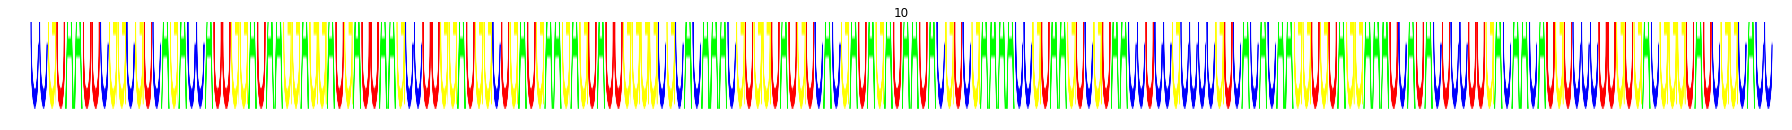

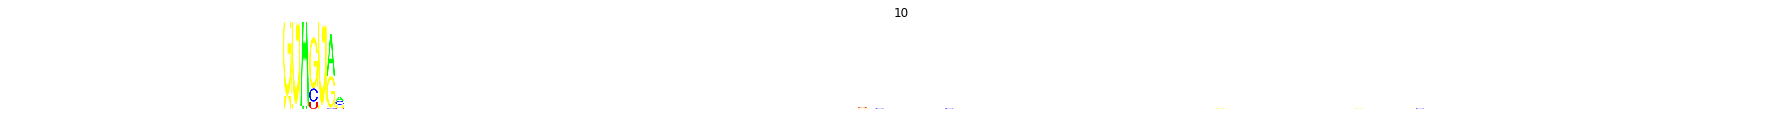

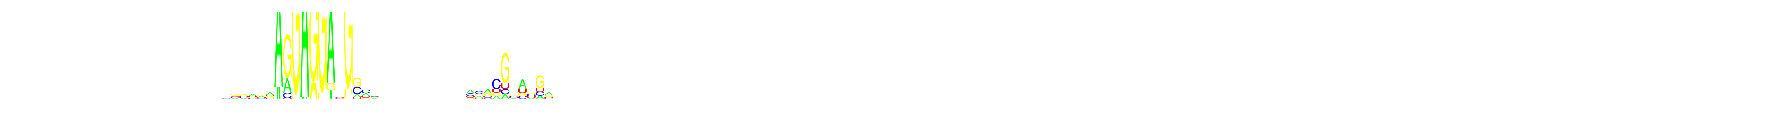

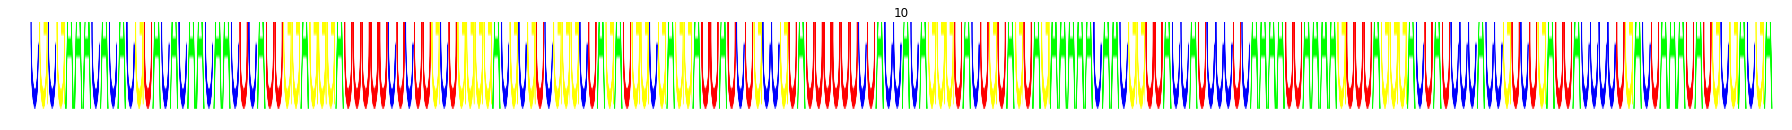

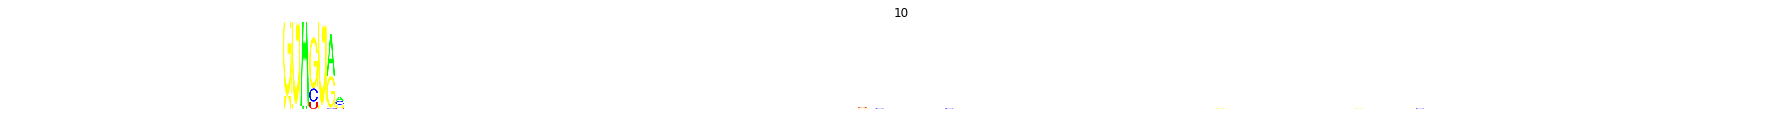

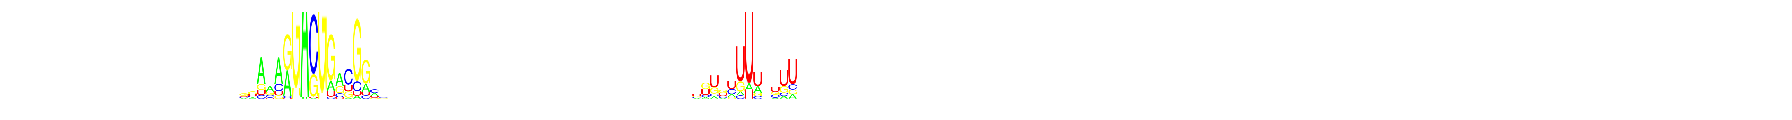

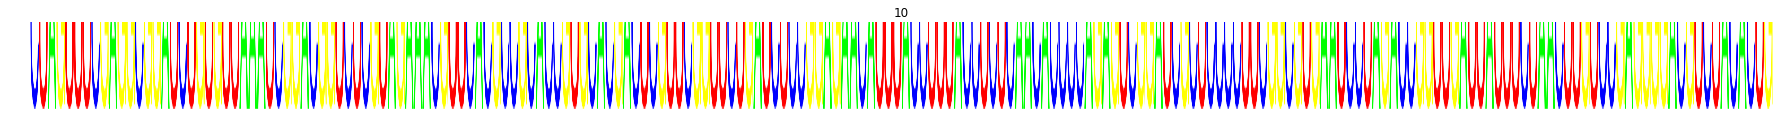

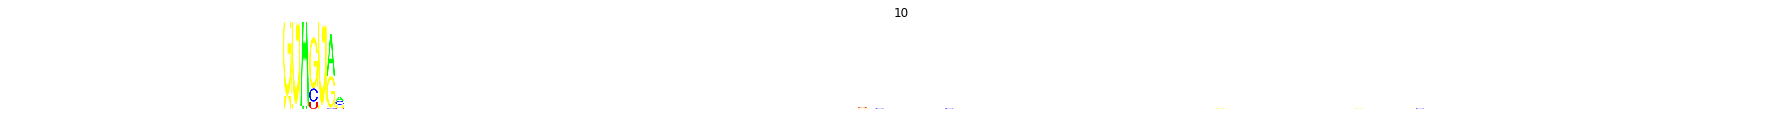

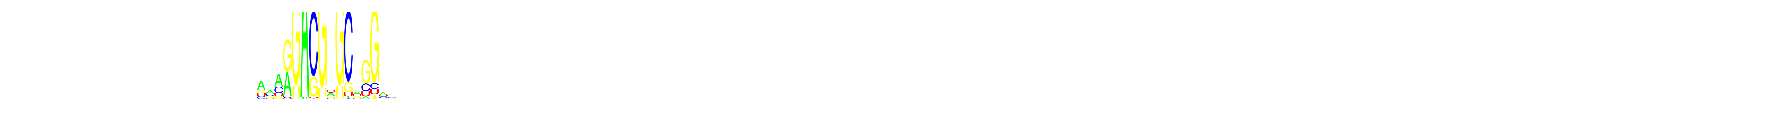

In [4008]:
class_index = 10

labels = np.argmax(train[1],axis=1)
index = np.where(labels == class_index)[0]

print 'ground truth = ' + str(class_index)
for i in index[:20]:
    map_index = i

    X = train[0][map_index]
    X = np.expand_dims(X,0)
    y = np.argmax(train[1][map_index])

    # get prediction
    get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
    prediction = get_prediction(X)
    prediction = np.argmax(prediction)

    x = IdentifyMotifs(X, prediction, nnmodel, network)

    height=300
    bp_width=30
    num_seq = X2.shape[1]
    width = bp_width*num_seq
    size = (25.,25.0)

    logo = seq_logo(np.squeeze(X[0]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(prediction));

    logo = seq_logo(np.squeeze(model[y]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(prediction));

    logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

12

# monitor prediciton effect for various filter thresholds 
Z = T.tensor4()
get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

vals = np.linspace(0,np.max(pool)+5,100)
z = []
for thresh in vals:
    test = np.copy(pool)
    test[test < thresh] = 0
    prediction2 = get_prediction2(test)
    z.append(prediction2[0])
z = np.array(z)

# plot the predictions
plt.figure()
plt.plot(vals,z);
z = z[:,prediction]
plt.plot(vals,z,linewidth=3,color='r')

# determine threshold to filter dense layer
MAX = vals[np.argmax(z)]
if MAX > 1:
    index = np.where(z>.7)[0]
    if index.any():
        MAX = vals[index[-1]]
threshold = MAX*.5
#threshold = np.mean(dense1[0]) + np.std(dense1[0])/2
num_units = len(dense[0])

plt.figure()
plt.plot(dense1[0])
plt.plot(range(num_units),np.ones(num_units)*threshold, color='r',linewidth=3)
print threshold

threshold = np.outer(threshold, np.ones(num_units))

val = np.squeeze(pool[0])

num_units = val.shape[1]
plt.plot(val.T);
threshold = np.mean(val) + np.std(val)*3
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)



spikes = np.squeeze(pool[0])

plt.figure()
#plt.errorbar(range(40), np.sum(spikes,axis=1), np.std(spikes,axis=1));
plt.plot(range(spikes.shape[1]), np.sum(spikes,axis=0));
sum_spikes = np.sum(spikes,axis=0)
threshold = np.mean(sum_spikes) + np.std(sum_spikes)
print threshold

intermediate = np.squeeze(pool[0])

# filter intermediate layer
window = 1


index = np.where(sum_spikes > threshold)[0]
print index
filter_map = np.zeros(intermediate.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(intermediate.shape[1],i+window)
    filter_map[:,MIN:MAX] = intermediate[:,MIN:MAX]
    
filter_map[filter_map < 1] = 0

plt.figure()
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


# determine threshold to filter conv2 layer
MAX = vals[np.argmax(z)]
if MAX > 1:
    index = np.where(z>.75)[0]
    if index.any():
        MAX = vals[index[-1]]
threshold = MAX*.5
# filter conv2 layer and plot activations
pool[pool < threshold] = 0

prediction2 = get_prediction2(pool)
print np.argmax(prediction2[0])
print prediction2[0]


plt.figure()
plt.plot(np.squeeze(pool[0].T));
#threshold = MAX*.5
threshold = np.minimum(MAX, 10)
threshold

intermediate = np.squeeze(pool[0])

# filter intermediate layer
window = 2

#for i in range(intermediate.shape[1]-window):
MAX = np.max(intermediate,axis=0)
index = np.where(MAX > threshold)[0]

filter_map = np.zeros(intermediate.shape)
for i in index:
    MIN = np.maximum(0, i-window)
    MAX = np.minimum(intermediate.shape[1],i+window)
    filter_map[:,MIN:MAX] = intermediate[:,MIN:MAX]
    
filter_map[filter_map < 0.2] = 0
plt.plot(filter_map.T)

filter_map = np.expand_dims(filter_map,0)
filter_map = np.expand_dims(filter_map,3)


# variance filter
var = np.var(x,axis=0)
num_units = len(var)
plt.figure()
plt.plot(var)
threshold = np.mean(var) + np.std(var)/2
plt.plot(range(num_units), np.ones(num_units)*threshold, color='r', linewidth=3)


In [3688]:
def IdentifyMotifs(X, prediction, nnmodel, network):
    
    # get dense layer
    get_dense1 = theano.function([nnmodel.input_var], layers.get_output(network['dense1_active'], deterministic=True), allow_input_downcast=True)
    dense1 = get_dense1(X)
    num_units = len(dense1)

    W = network['dense2'].W.get_value()
    b = network['dense2_bias'].b.get_value()
    
    # monitor prediciton effect for various filter thresholds 
    Z = T.dmatrix()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['dense1_active']:Z}, deterministic=True), allow_input_downcast=True)

    vals = np.linspace(0,20,50)
    threshold = []
    z = []
    for thresh in vals:
        test = np.copy(dense1)
        test[test < thresh] = 0
        prediction2 = get_prediction2(test)
        z.append(prediction2[0])
    z = np.array(z)
    z = z[:,prediction]
    
    # determine threshold to filter dense layer
    MAX = vals[np.argmax(z)]
    
    if MAX > 1:
        index = np.where(z>.7)[0]
        if index.any():
            MAX = vals[index[-1]]
    threshold.append(MAX*.8)
    threshold = np.array(threshold)
    threshold = np.outer(threshold, np.ones(num_units))
    
    # filter dense layer and plot activations
    dense1[dense1 < threshold] = 0
    prediction2 = get_prediction2(dense1)

    W = network['dense1'].W.get_value()
    b = network['dense1_bias'].b.get_value()

    # psuedo-inverse filters
    U, s, V = np.linalg.svd(W, full_matrices=True)
    S = np.zeros(W.T.shape)
    S[:W.shape[1],:W.shape[1]] = np.diag(1/s)
    Winv = np.dot(V.T,np.dot(S, U.T))

    # inverse the activation
    inverse = dense1 # np.log(np.exp(dense1) + 1e-7)
    inverse -= np.outer(np.ones(num_units),b)
    inverse = np.dot(inverse, W.T)

    shape = get_output_shape(network['conv2_pool'])
    shape = (-1, shape[1], shape[2], shape[3])
    pool = inverse.reshape(shape)

    Z = T.dmatrix()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)

    test = np.reshape(pool,[1,-1])
    prediction2 = get_prediction2(test)
    
    # monitor prediciton effect for various filter thresholds 
    Z = T.tensor4()
    get_prediction2 = theano.function([Z], get_output(network['output'], {network['conv2_pool']:Z}, deterministic=True), allow_input_downcast=True)
    vals = np.linspace(0,50,50)
    threshold = []
    z = []
    for thresh in vals:
        test = np.copy(pool)
        test[test < thresh] = 0
        prediction2 = get_prediction2(test)
        z.append(prediction2[0])
    z = np.array(z)
    z = z[:,prediction]
    
    # determine threshold to filter conv2 layer
    MAX = vals[np.argmax(z)]
    if MAX > 1:
        index = np.where(z>.7)[0]
        if index.any():
            MAX = vals[index[-1]]
    threshold.append(MAX*.8)
    threshold = np.array(threshold)
    threshold = np.outer(threshold, np.ones(num_units))

    # filter conv2 layer and plot activations
    pool[pool < threshold] = 0
    prediction2 = get_prediction2(pool)

    # max-unpool layer 2
    active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
    pool_size = active.shape[2]/pool.shape[2]
    fmap2 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index= []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):

            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap2.append(fmap_unpool)

    fmap2 = np.array(fmap2)
    fmap2 = np.expand_dims(fmap2, 3)
    # psuedo-inverse filters
    W2 = network['conv2'].W.get_value()
    W2_inv = pseudoinverse_filter2(W2)

    # deconvolution layer 2
    input_var2 = T.tensor4('fmap')
    shape2 = list(fmap2.shape)
    shape2[0] = None
    input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
    unpool2 = BiasLayer(input2, b=-network['conv2_bias'].b)
    deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
    predict = theano.function([input_var2], get_output(deconv2, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap2.astype(np.float32))
    intermediate = np.array(intermediate)

    #plt.plot(np.squeeze(intermediate[0]).T);
    
    # filter intermediate layer
    intermediate[intermediate < 0.5] = 0

    pool = intermediate

    # max-unpool layer 1
    active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)


    W1 = network['conv1'].W.get_value()
    W1_inv = pseudoinverse_filter2(W1)


    # deconvolution layer 1
    input_var1 = T.tensor4('fmap')
    shape1 = list(fmap1.shape)
    shape1[0] = None
    input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
    unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
    deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)


    reconstruction = theano.function([input_var1], get_output(deconv1, deterministic=True), allow_input_downcast=True)
    X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))
    return X2







ground truth = 4
prediction = 4


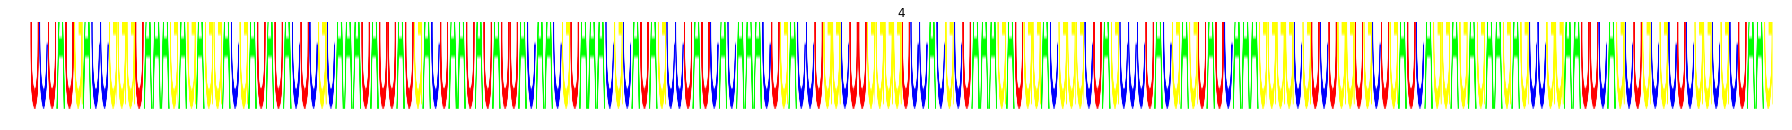

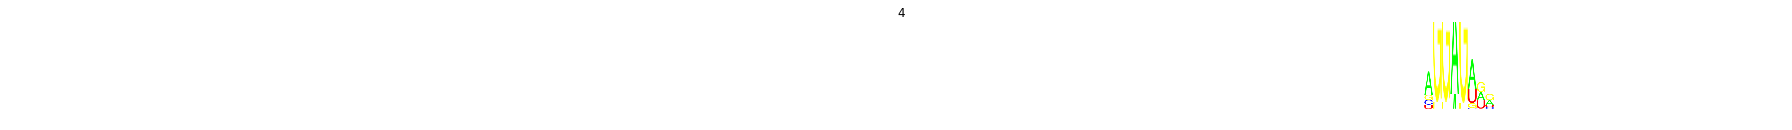

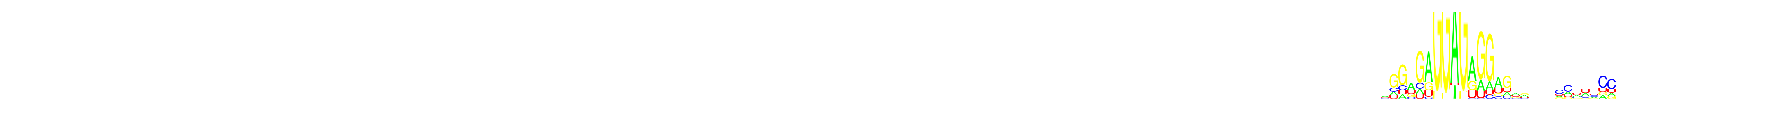

In [3690]:
#X2, labels = reconstruct_layer2(network, train)
map_index = 7

X = train[0][map_index]
X = np.expand_dims(X,0)
y = np.argmax(train[1][map_index])

# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
prediction = np.argmax(prediction)
print 'ground truth = ' + str(y)
print 'prediction = ' + str(prediction)

X2 = IdentifyMotifs(X, prediction, nnmodel, network)

height=300
bp_width=30
num_seq = X2.shape[1]
width = bp_width*num_seq
size = (25.,25.0)


logo = seq_logo(np.squeeze(X[0]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));


logo = seq_logo(np.squeeze(model[y]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);
plt.imshow(logo, interpolation='none');
plt.axis('off');
plt.title(str(y));

x = X2
for i in range(5):
    x[:,:10]=0
    x[:,-10:]=0
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))

#x -= np.max(x, axis=0)
#x -= np.min(x, axis=0)
x /= np.log(2)
x = np.exp(x)
sumX = np.sum(x,axis=0) 
x /= np.outer(np.ones(4),sumX)
logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

## Multiple sequences

In [400]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(5000)
X = train[0][map_index]
y = np.argmax(train[1][map_index], axis=1)

# psuedo-inverse filters
W3 = network['dense1'].W.get_value()
b3 = network['dense1_bias'].b.get_value()
dense1 = get_feature_map(network['dense1_active'], nnmodel.input_var, X, map_index)

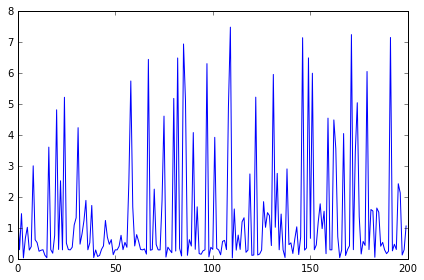

In [401]:
plt.figure()
plt.plot(dense1[0])

In [407]:
z = []
for thresh in vals:
    test = np.copy(dense1[index])
    test[test < thresh] = 0
    z.append(np.dot(W.T,test) + b)
z = np.array(z)
print z.shape
print np.argmax(z,axis=0)


(50, 20)
[20 22 22 20 22 22 22 22 22 22 22 10 22 22 19 22 22 22 22 22]


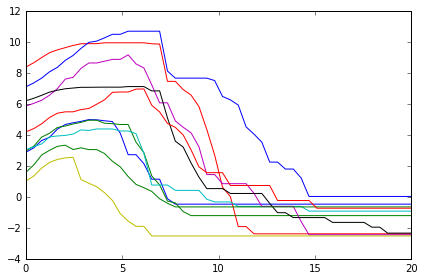

In [402]:
W = network['dense2'].W.get_value()
b = network['dense2_bias'].b.get_value()


plot_index = range(10)
vals = np.linspace(0,20,50)
threshold = []
for index in map_index:
    z = []
    for thresh in vals:
        test = np.copy(dense1[index])
        test[test < thresh] = 0
        z.append(np.dot(W.T,test) + b)
    z = np.array(z)
    z[np.argmax(z,axis=0)]
    
    z = z[:,y[index]]
    if index in plot_index:
        plt.plot(vals,z);
    MAX = vals[np.argmax(z)]
    #MAX = vals[np.argmax(np.where(z > 1)[0])]
    threshold.append(MAX)

threshold = np.array(threshold)
threshold = np.outer(threshold, np.ones(dense1.shape[1]))


In [347]:
# filter dense layer
#dense1[dense1 < threshold] = 0
bias3 = dense1-np.outer(np.ones(dense1.shape[0]),b3)
inv3 = bias3# np.log(np.exp(bias3) + 1e-7)
active3 = np.dot(inv3, W3.T)

pool=get_feature_map_all(network['conv2_pool'], nnmodel.input_var, X)
pool = active3.reshape(pool.shape)

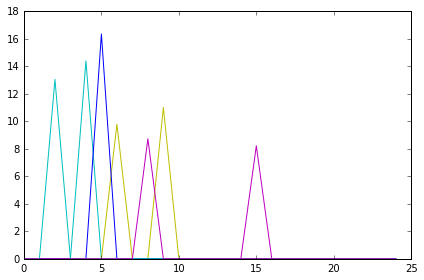

In [350]:
plt.figure()
plt.plot(np.squeeze(pool[0].T));

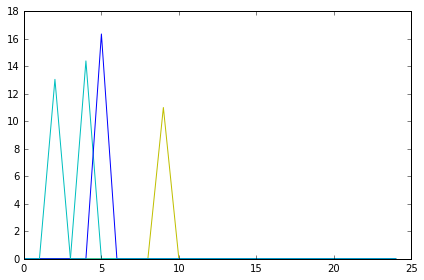

In [351]:
pool[pool<10] = 0
pool[:,:,:2]=0
pool[:,:,-2:]=0

plt.figure()
plt.plot(np.squeeze(pool[0].T));

In [352]:
# psuedo-inverse filters
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)
W2_inv = pseudoinverse_filter2(W2)

# max-unpool layer 2
active = get_feature_map_all(network['conv2_active'], nnmodel.input_var, X)
#


pool_size = active.shape[2]/pool.shape[2]
fmap2 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index= []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)


In [353]:
# deconvolution layer 2
input_var2 = T.tensor4('fmap')
shape2 = list(fmap2.shape)
shape2[0] = None
input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
#unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool2 = BiasLayer(input2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv2)
prediction = theano.function([input_var2], prediction, allow_input_downcast=True)

intermediate = prediction(fmap2.astype(np.float32))
intermediate = np.array(intermediate)

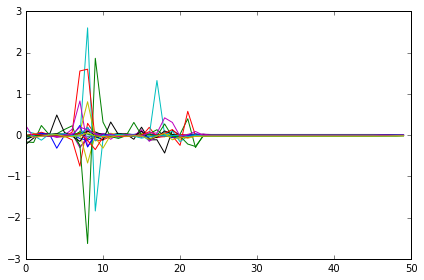

In [354]:
plt.plot(np.squeeze(intermediate[0]).T);

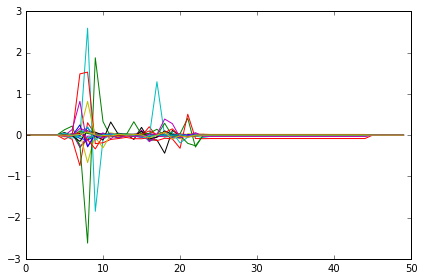

In [355]:
for i in range(len(intermediate)):
    for j in range(5):
        x = np.squeeze(intermediate[i])
        x[:,:5]=0
        x[:,-5:]=0
        MEAN = np.mean(intermediate[i], axis=1)
        x -= np.outer(MEAN, np.ones(x.shape[1]))
        intermediate[i] = np.expand_dims(x,2)    
plt.plot(np.squeeze(intermediate[0]).T);

In [356]:
val=.8
intermediate[intermediate < val] = 0

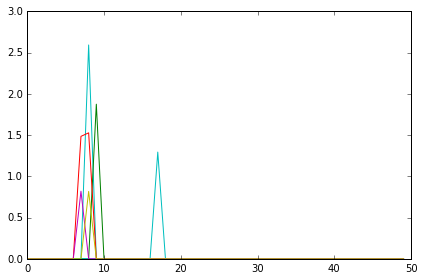

In [357]:
plt.plot(np.squeeze(intermediate[0]).T);

In [392]:
pool = intermediate

# max-unpool layer 1
active = get_feature_map_all(network['conv1_active'], nnmodel.input_var,X)

pool_size = active.shape[2]/pool.shape[2]
fmap1 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap1.append(fmap_unpool)

fmap1 = np.array(fmap1)
fmap1 = np.expand_dims(fmap1, 3)

# deconvolution layer 1
input_var1 = T.tensor4('fmap')
shape1 = list(fmap1.shape)
shape1[0] = None
input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)

prediction = get_output(deconv1)
reconstruction = theano.function([input_var1], prediction, allow_input_downcast=True)

In [395]:
X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

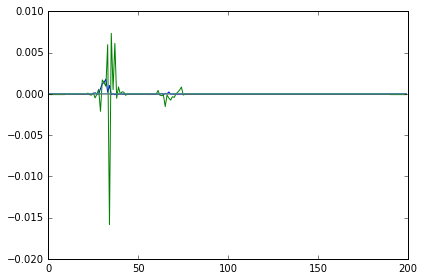

In [394]:
index = 0
x = np.squeeze(X2[index])

for i in range(5):
    x[:,:10]=0
    x[:,-10:]=0
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
plt.plot(x.T);





4.4451992679285892

In [390]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            for i in range(5):
                x[:,:10]=0
                x[:,-10:]=0
                MEAN = np.nanmean(x,axis=1)
                x -= np.outer(MEAN, np.ones(x.shape[1]))
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm

model = []
for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    model.append(get_class_pwm(np.squeeze(X), class_index))


SyntaxError: invalid syntax (<ipython-input-390-b77719491fc0>, line 13)

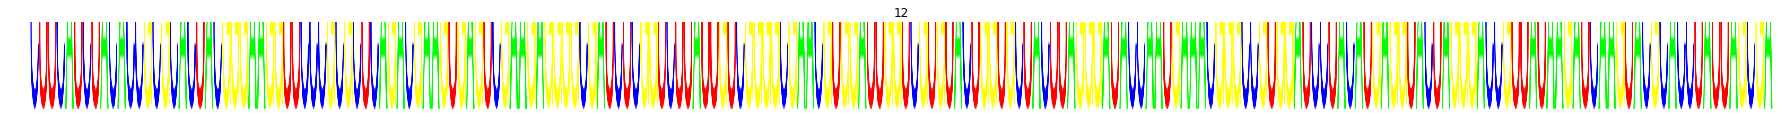

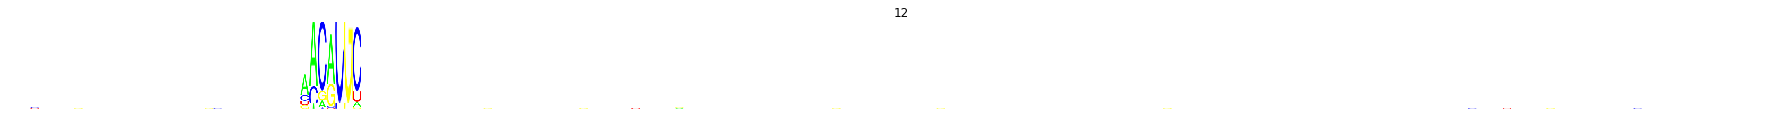

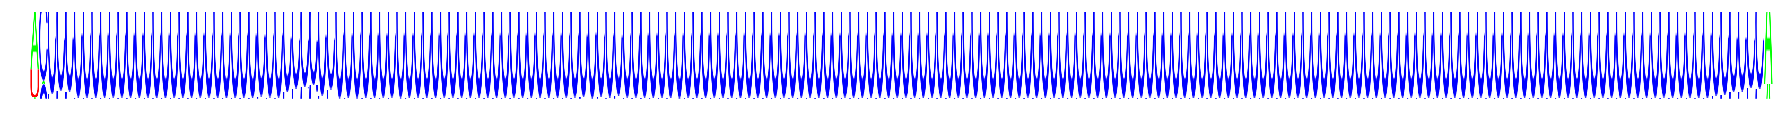

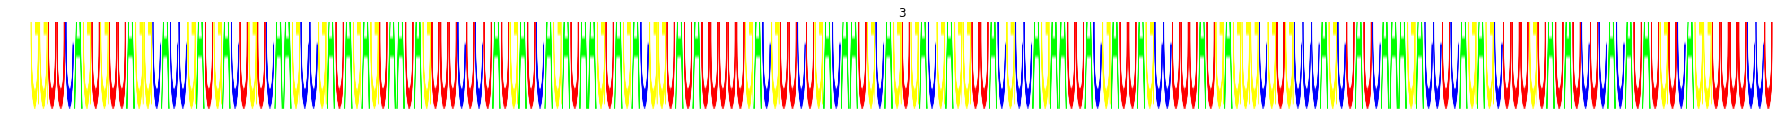

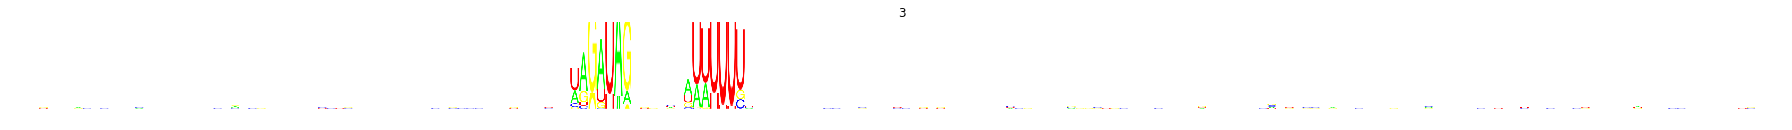

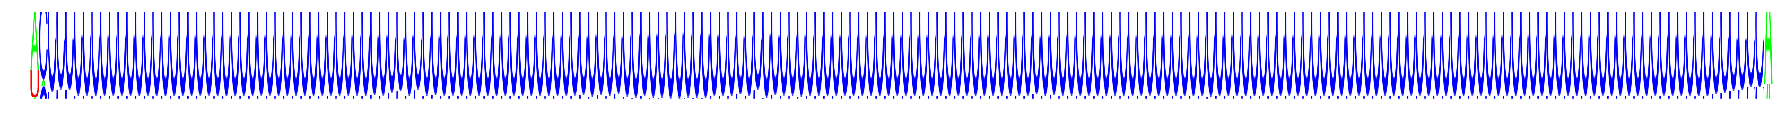

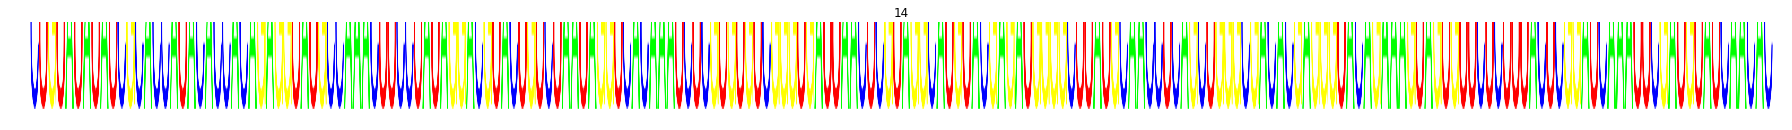

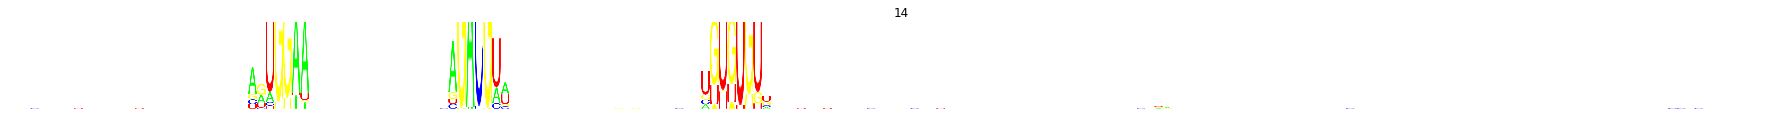

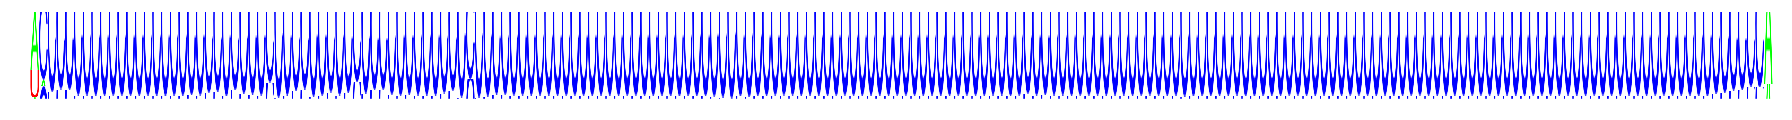

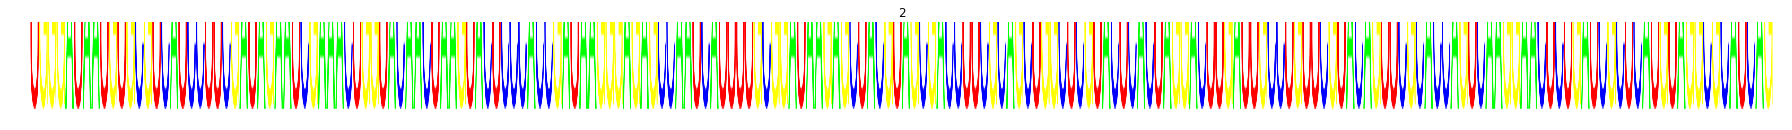

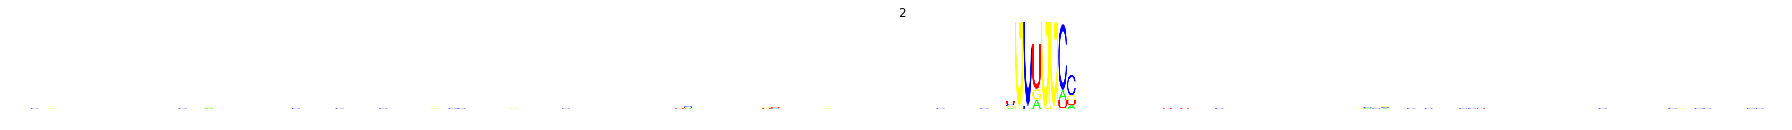

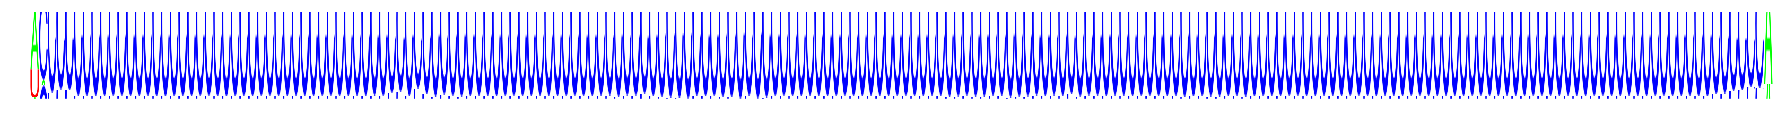

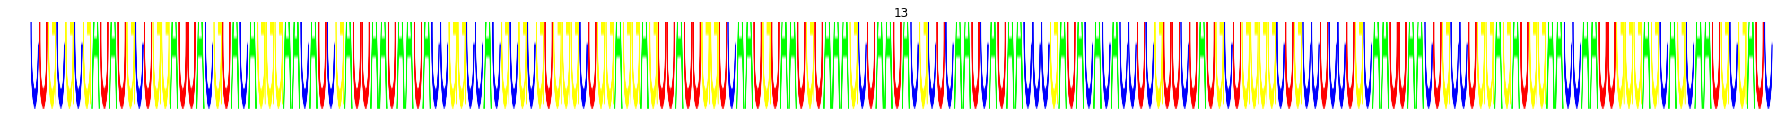

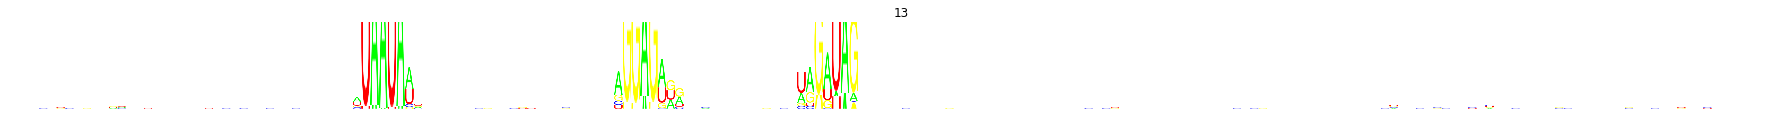

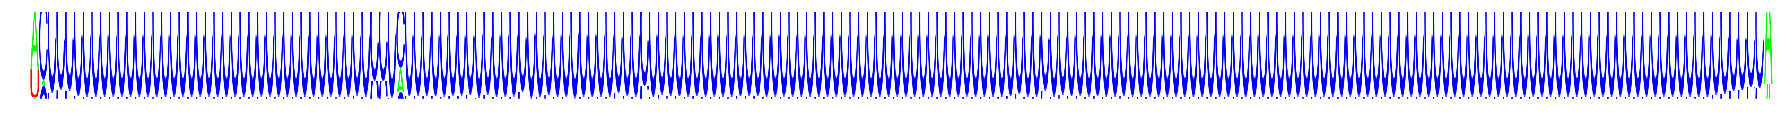

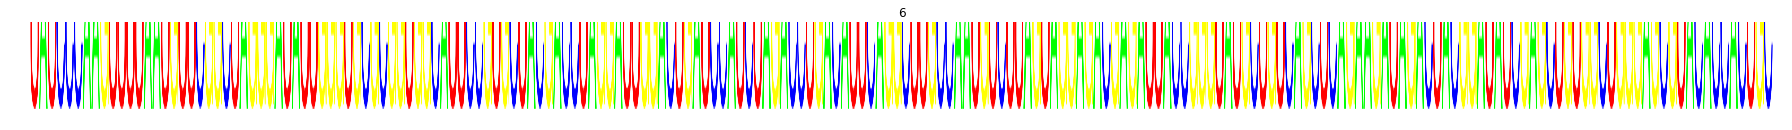

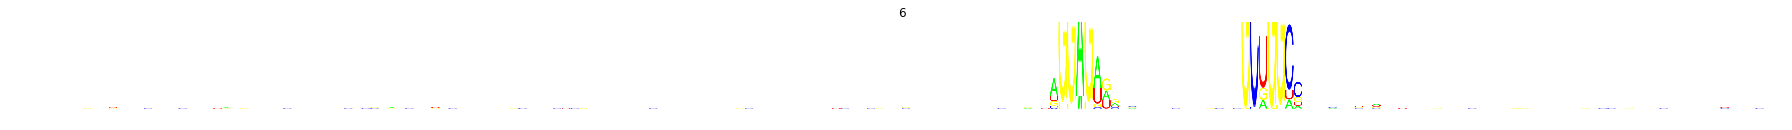

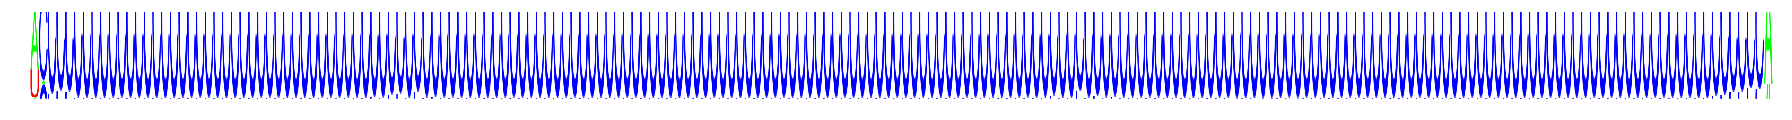

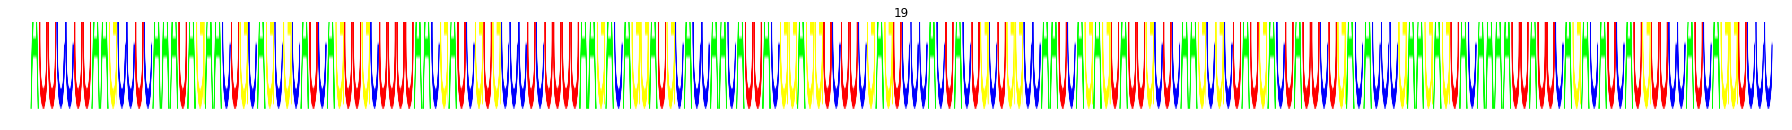

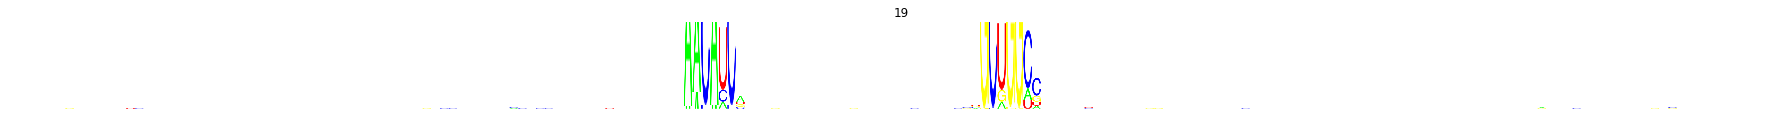

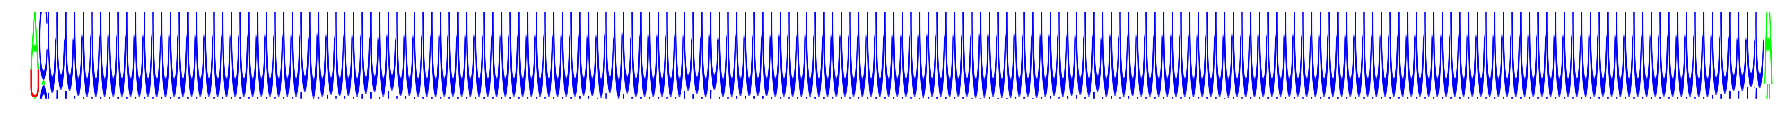

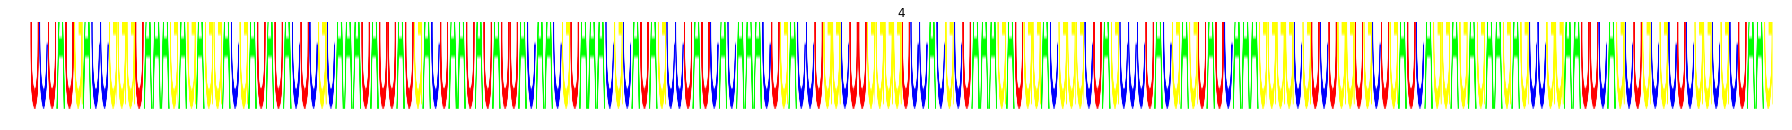

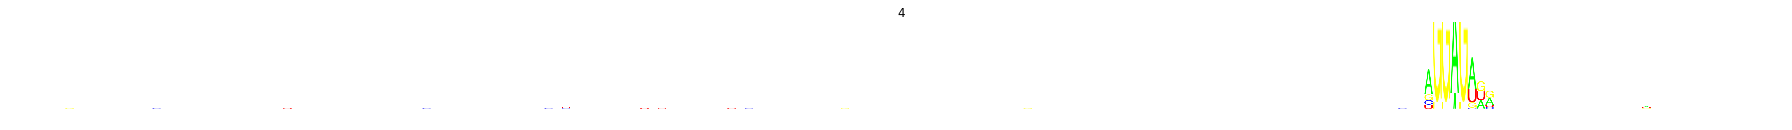

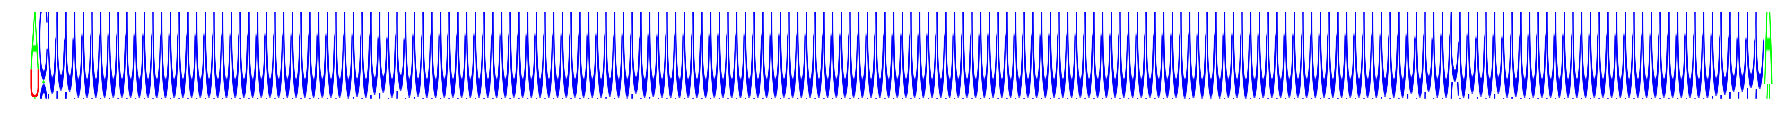

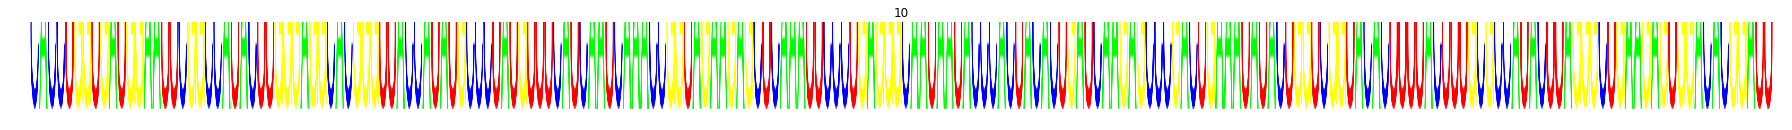

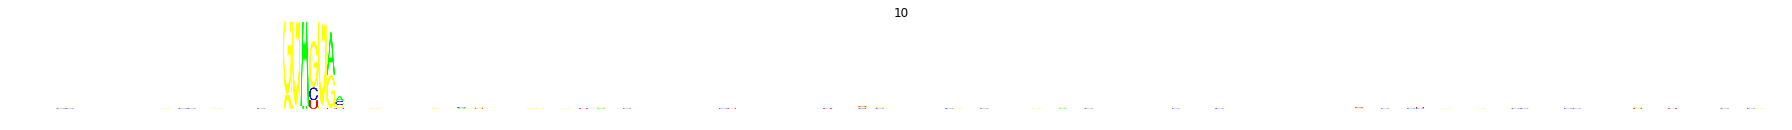

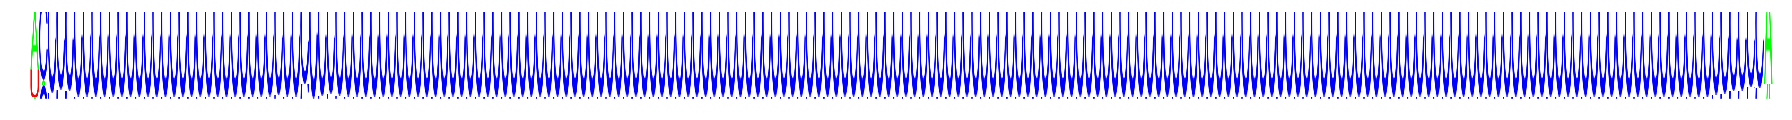

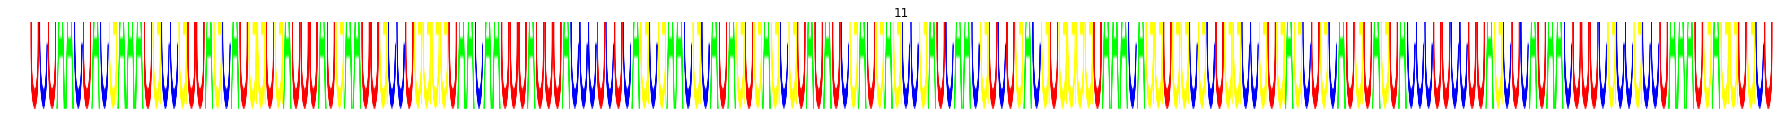

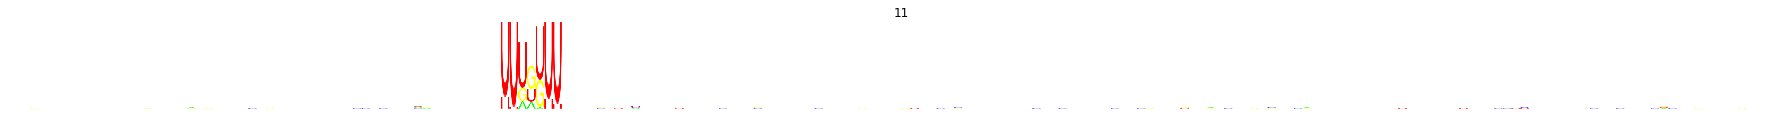

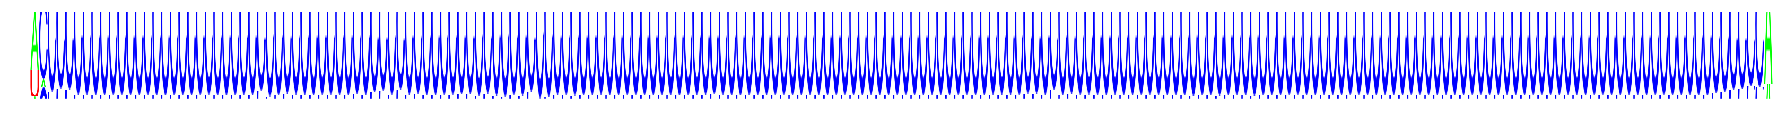

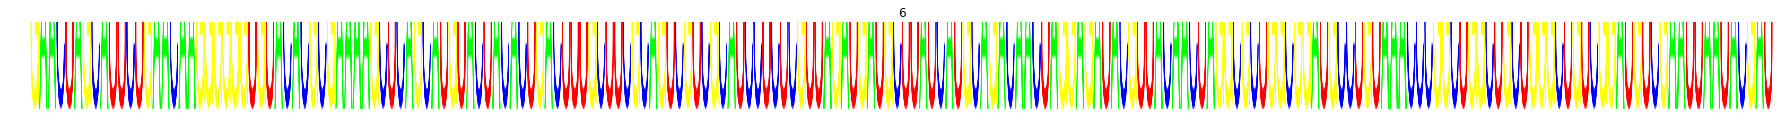

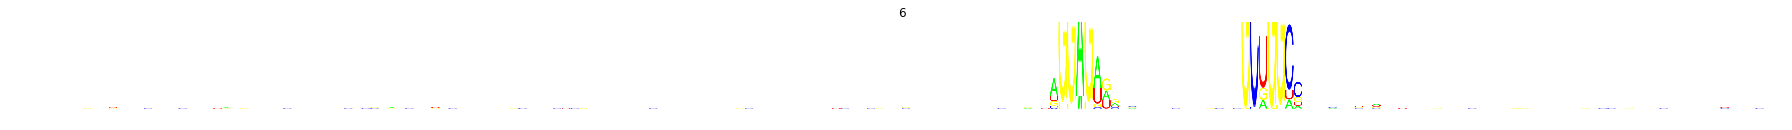

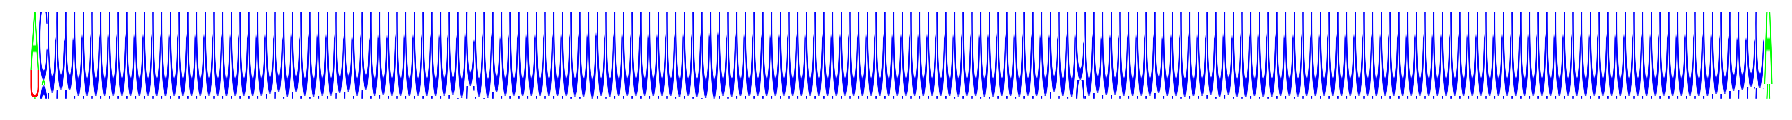

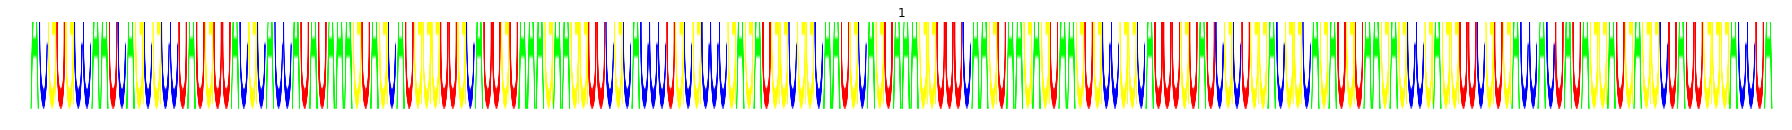

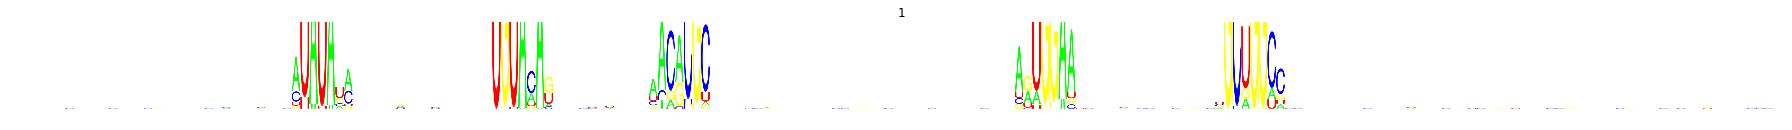

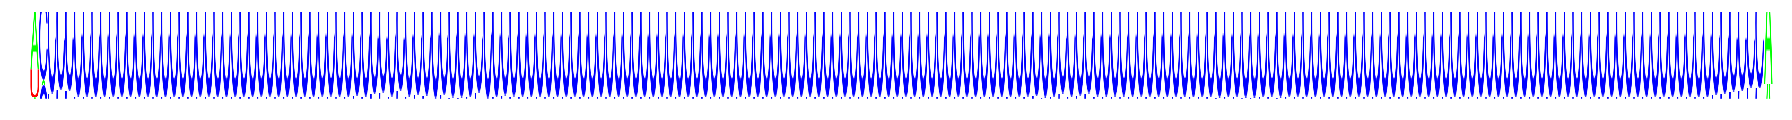

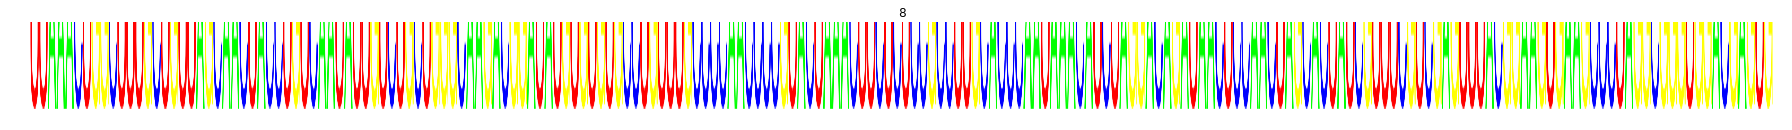

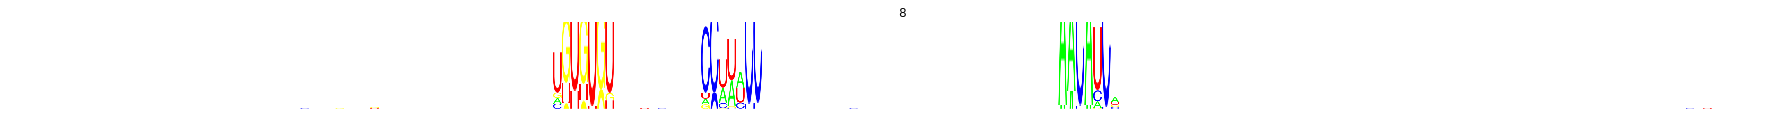

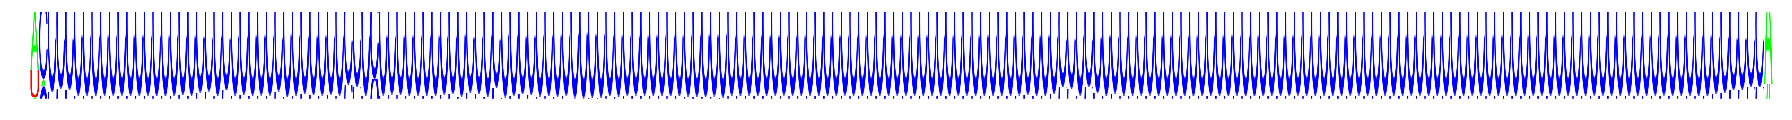

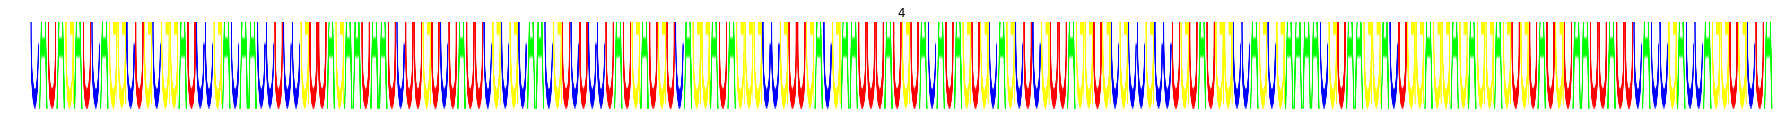

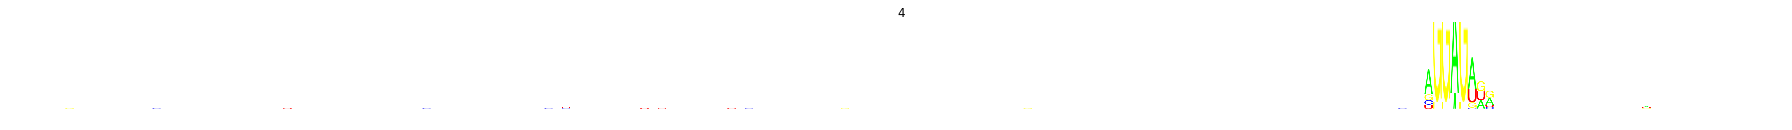

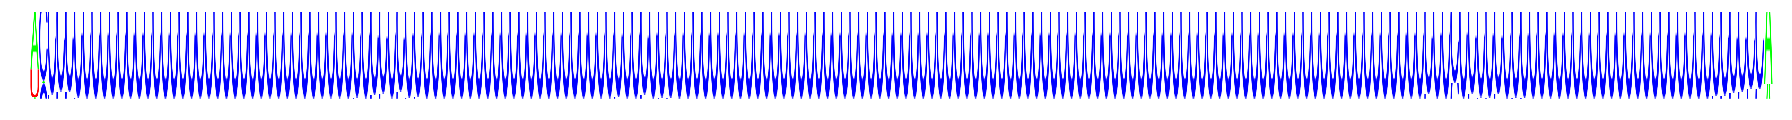

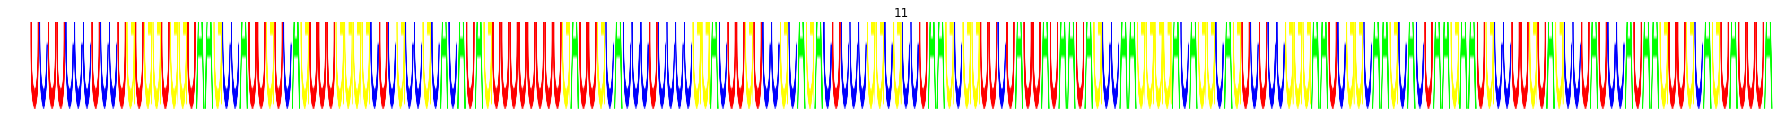

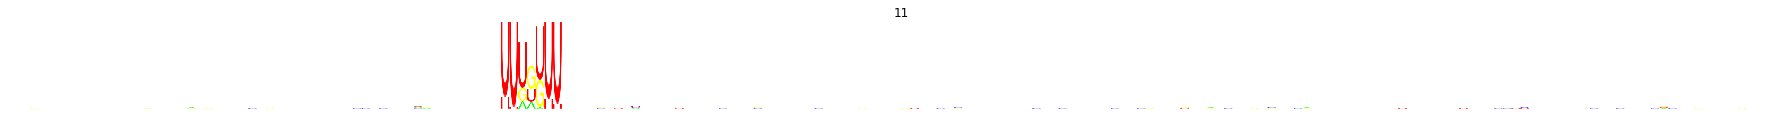

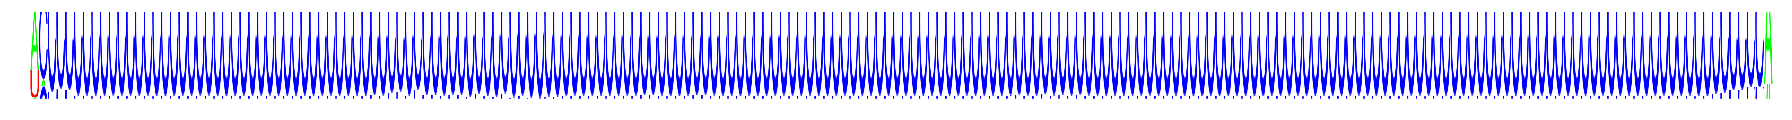

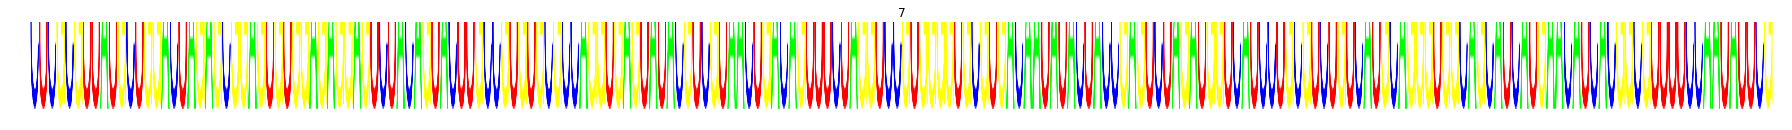

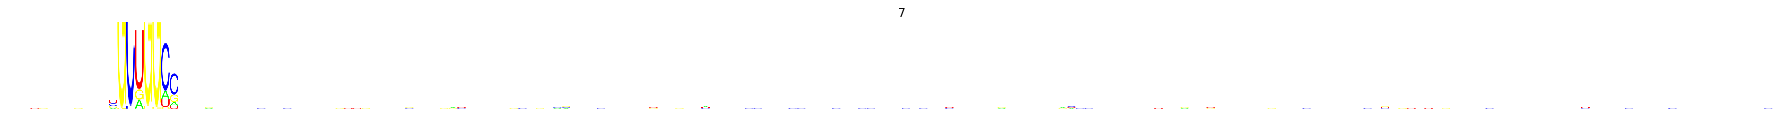

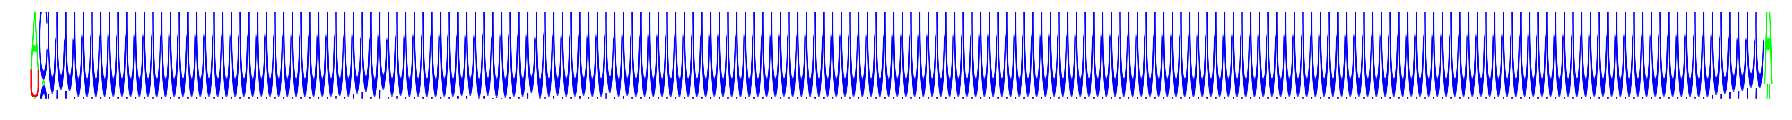

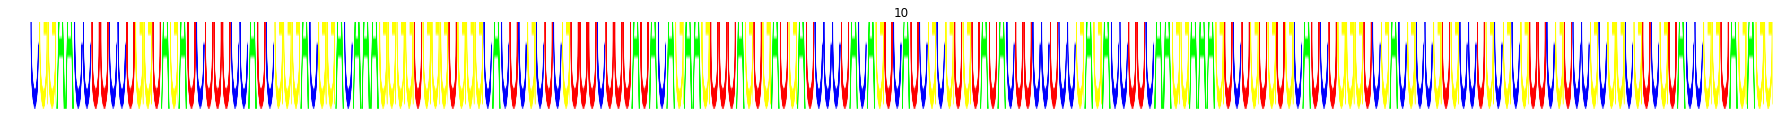

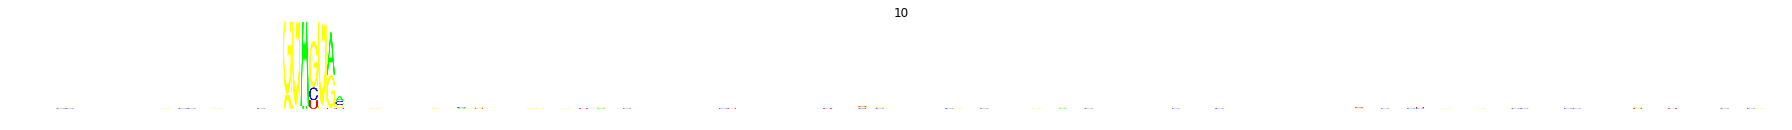

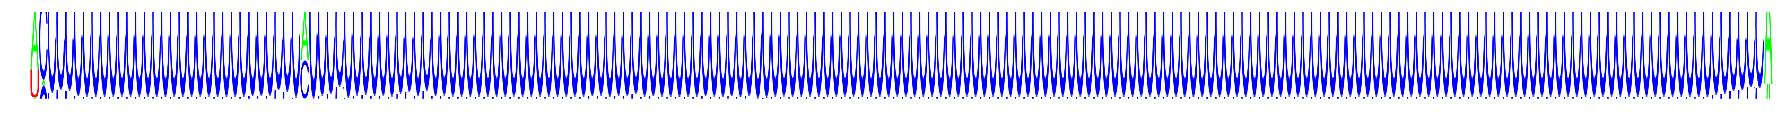

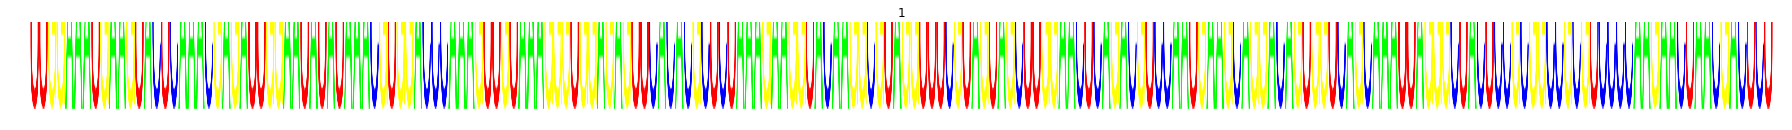

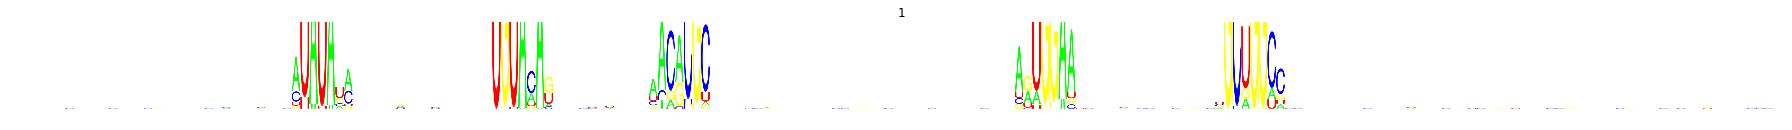

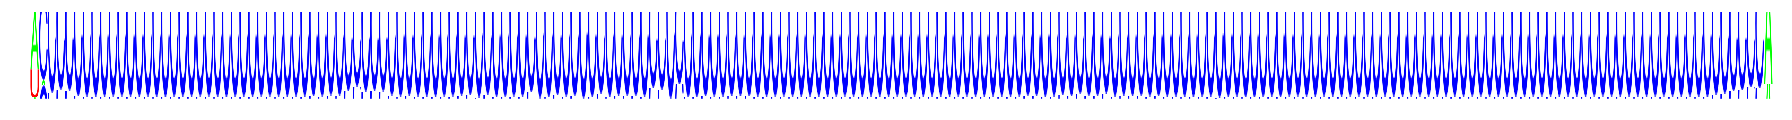

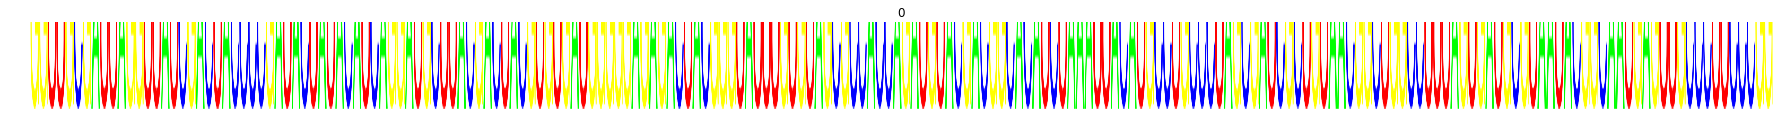

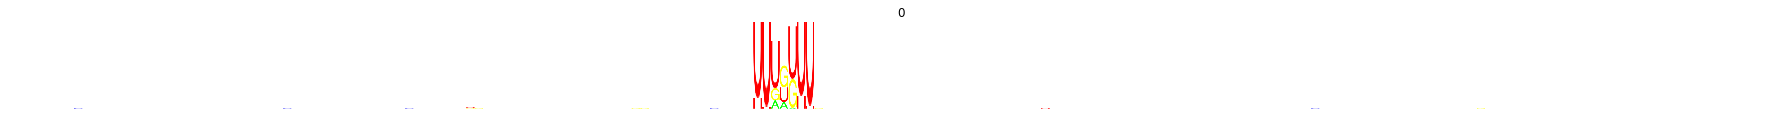

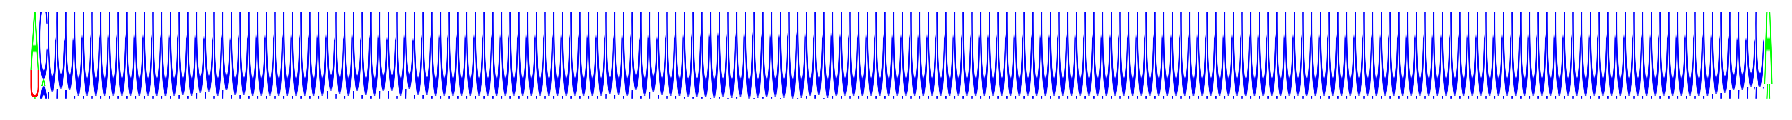

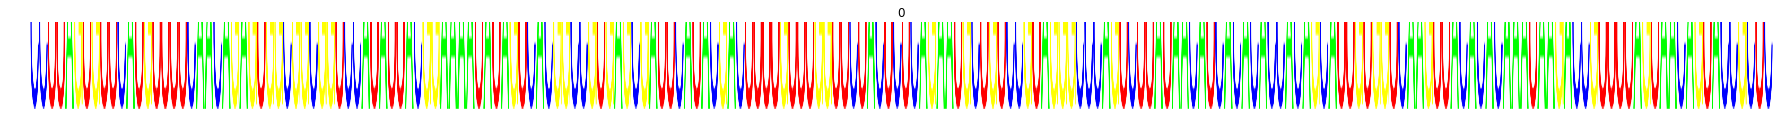

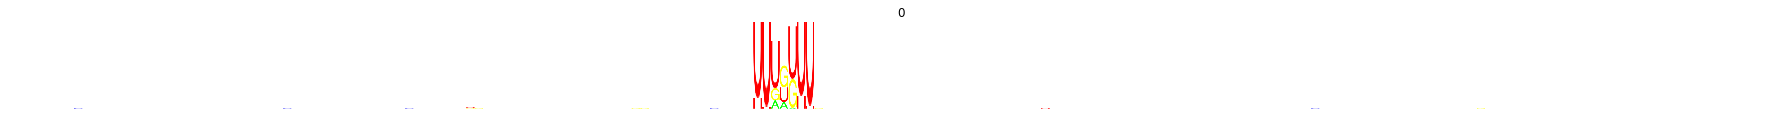

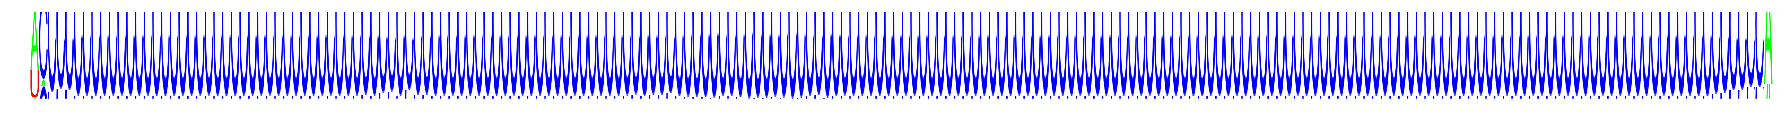

In [399]:
for index in range(20):
    
    height=300
    bp_width=30
    num_seq = X2.shape[2]
    width = bp_width*num_seq
    size = (25.,25.0)

    logo = seq_logo(np.squeeze(train[0][map_index[index]]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    plt.title(str(y[index]))
    
    logo = seq_logo(model[y[index]], height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    plt.title(str(y[index]))

    
    x = np.squeeze(X2[index])
    for i in range(5):
        x[:,:10]=0
        x[:,-10:]=0
        MEAN = np.nanmean(x,axis=1)
        x -= np.outer(MEAN, np.ones(x.shape[1]))

    #x -= np.max(x, axis=0)
    x = np.exp(x)
    #x = np.exp(x)
    #x -= np.min(x, axis=0)
    sumX = np.sum(x,axis=0)
    x /= np.outer(np.ones(4),sumX)
    logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
